### LeakyPDB test set predicitons

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error
from scipy.constants import R, kilo
from typing import Tuple
from scipy.stats import pearsonr, spearmanr

In [4]:
def pkd_to_dg(
    pkd: float,
    uncertainty: float,
    temperature: float = 298.15
) -> Tuple[float, float]:
    """
    Convert the pKd value and its uncertainty to ΔG.

    Args:
        pkd: The pKd value.
        uncertainty: The standard deviation in the pKd value.
        temperature: Experimental temperature in Kelvin. Default: 298.15 K.

    Returns:
        dg: Gibbs binding free energy in kilocalories per mole.
        ddg: Error in binding free energy in kilocalories per mole.
    """
    # Convert pKd to Kd (dissociation constant in molar)
    kd = 10 ** (-pkd)  # Convert to molar from nM 
    
    # Calculate ΔG
    dg = R * temperature * np.log(kd) / kilo  # Convert J to kJ, then to kcal (1 kcal = 4184 J)
    dg_kcal_per_mol = dg / 4.184  # Convert kJ to kcal

    # Calculate the uncertainty in ΔG
    ddg = R * temperature * np.log(10) * uncertainty / kilo
    ddg_kcal_per_mol = ddg / 4.184  # Convert kJ to kcal

    return dg_kcal_per_mol, ddg_kcal_per_mol

#### Entire Test set

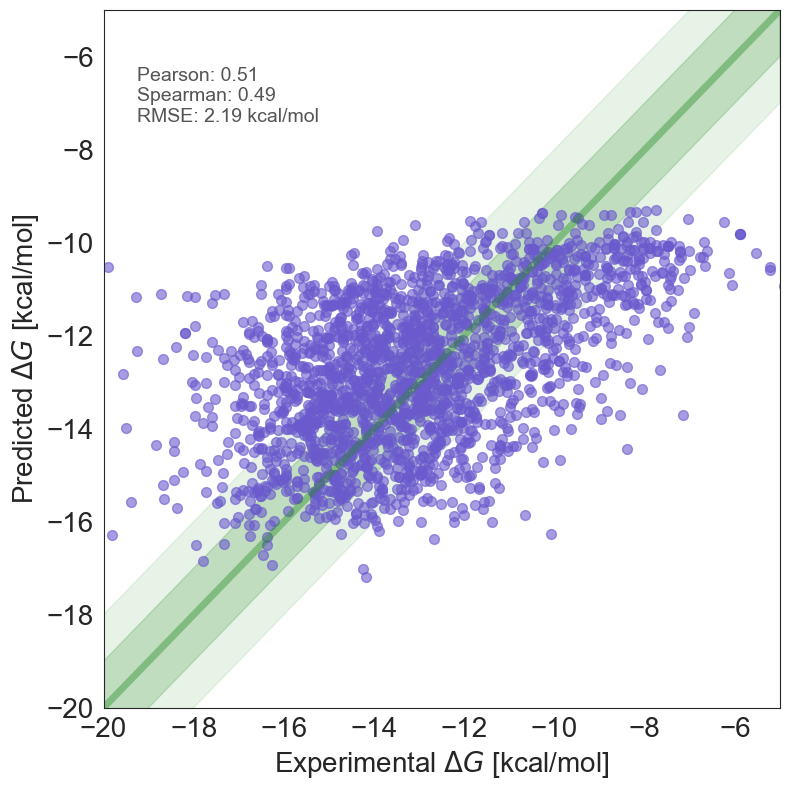

In [34]:
file_path = 'data/LeakyPDB_BALM+PEFT_new.csv'
data = pd.read_csv(file_path)
uncertainty_value = 0.1
data['label_dG'] = data.apply(lambda row: pkd_to_dg(row['label'],uncertainty_value)[0], axis=1)
#data['prediction_dG'] = data.apply(lambda row: pkd_to_dg(row['prediction'], uncertainty_value)[0], axis=1)
data['prediction_dG'] = data.apply(lambda row: pkd_to_dg(row['prediction'], uncertainty_value)[0], axis=1)
# Randomly select 10% of the data
sampled_data = data.sample(frac=1, random_state=20)

# Calculate Pearson and Spearman correlations
pearson_corr, _ = pearsonr(sampled_data['label_dG'], sampled_data['prediction_dG'])
spearman_corr, _ = spearmanr(sampled_data['label_dG'], sampled_data['prediction_dG'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(sampled_data['label_dG'], sampled_data['prediction_dG']))

# Scatter plot with white background and using the specified colors for shaded bands
sns.set_style("white")

plt.figure(figsize=(8, 8))

# Adding identity line with shaded bands using Forest Green and Slate Blue
x = np.linspace(-20, -5, 100)
y = x
plt.plot(x, y, color='#228B22', linestyle='-', linewidth=5, alpha=0.4)

plt.fill_between(x, y - 1, y + 1, color='#228B22', alpha=0.2)  # Forest Green
plt.fill_between(x, y - 2, y + 2, color='#228B22', alpha=0.1)  

plt.scatter(sampled_data['label_dG'], sampled_data['prediction_dG'], color='#6A5ACD', alpha=0.6, s=50)

plt.xlim(-20, -5)
plt.ylim(-20, -5)


plt.ylabel(r'Predicted $\Delta G$ [kcal/mol]', fontsize=20)
plt.xlabel(r'Experimental $\Delta G$ [kcal/mol]', fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.text(-19.25, -7.5, f'Pearson: {pearson_corr:.2f}\nSpearman: {spearman_corr:.2f}\nRMSE: {rmse:.2f} kcal/mol', 
         fontsize=14, verticalalignment='bottom', color='#555555',  # Slate Blue for text
         bbox=dict(facecolor='white', alpha=0.01, edgecolor='white'))

plt.tight_layout()
plt.show()

#### Per target predictions (targets having at least 10 ligand interactions)

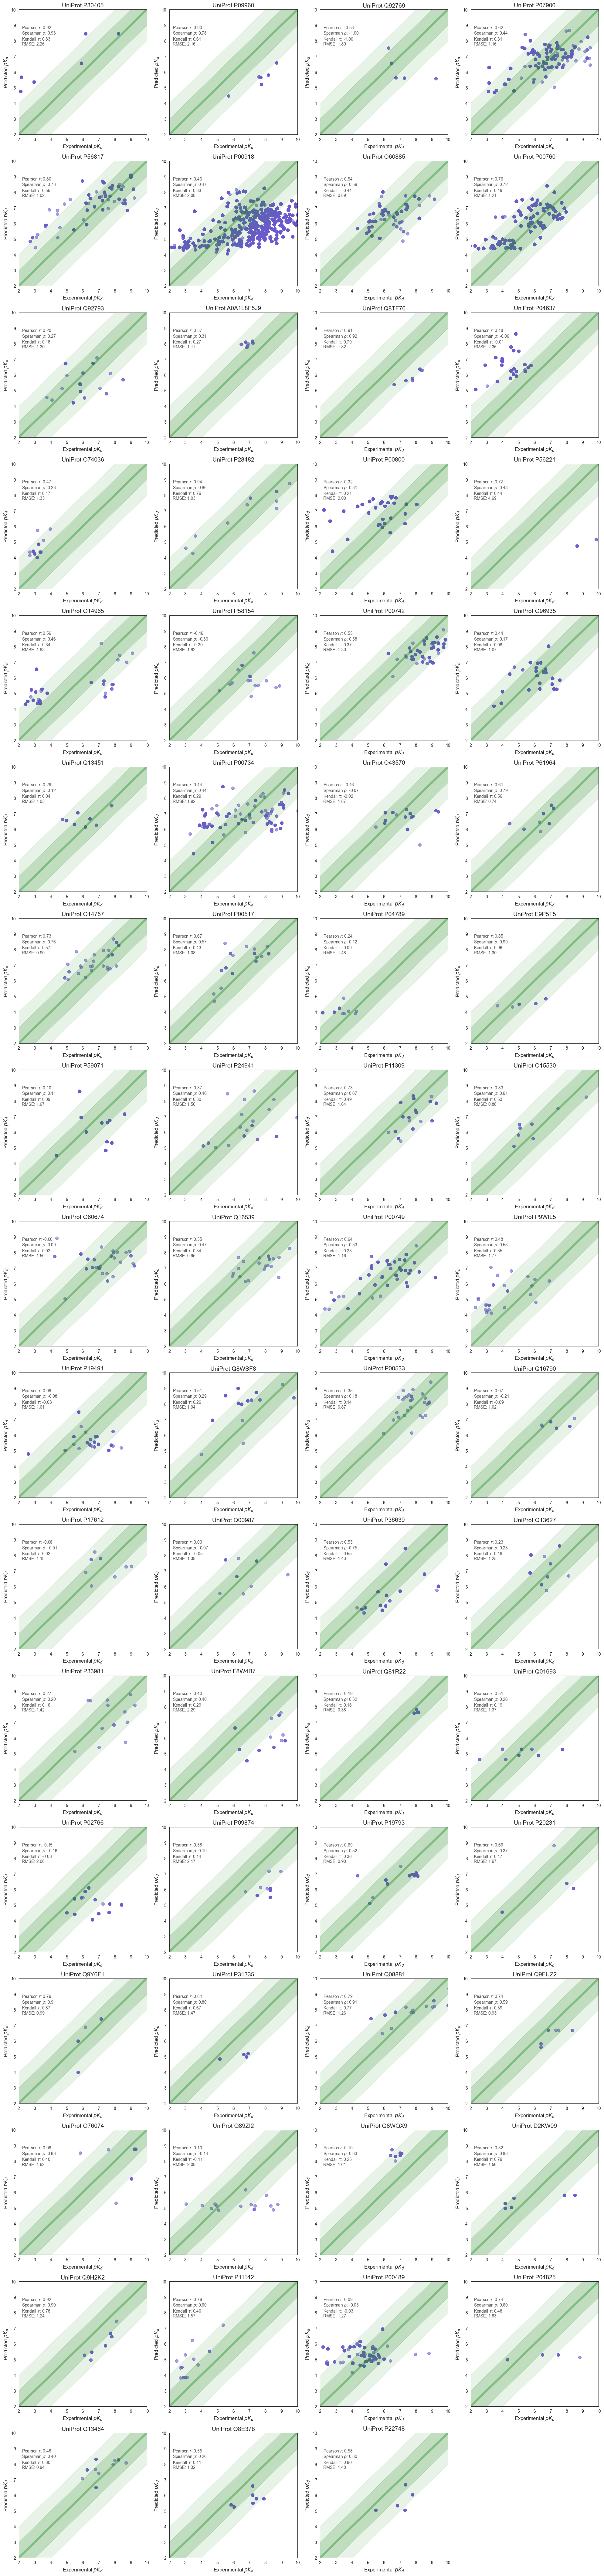

In [36]:
# Load the predictions and test set data
predictions_file = 'data/LeakyPDB_BALM+PEFT_new.csv'
test_set_file = 'data/test_set_with_uniprot.csv'

# Load prediction data
predictions = pd.read_csv(predictions_file)

# Load test set data with Uniprot ID and PDB ID information
test_set = pd.read_csv(test_set_file)

# Merge prediction data with test set based on protein sequence
merged_data = pd.merge(predictions, test_set, left_on='protein', right_on='Target', how='left')

# Filter out rows where UniProt ID is null
merged_data = merged_data[~merged_data['UniProt_ID'].isnull()]

# Filter targets with at least 10 data points based on UniProt ID
target_counts_uniprot = merged_data['UniProt_ID'].value_counts()
targets_to_plot_uniprot = target_counts_uniprot[target_counts_uniprot >= 10].index

# Now filter the data to only include these targets
filtered_data_uniprot = merged_data[merged_data['UniProt_ID'].isin(targets_to_plot_uniprot)]

# Plot predictions for each UniProt ID
unique_targets_uniprot = filtered_data_uniprot['UniProt_ID'].unique()
n_targets_uniprot = len(unique_targets_uniprot)

# Define the number of rows and columns for subplots
n_cols = 4  # Adjust as needed
n_rows_uniprot = (n_targets_uniprot // n_cols) + (n_targets_uniprot % n_cols > 0)

# Create a figure and subplots for UniProt ID plots
fig_uniprot, axes_uniprot = plt.subplots(n_rows_uniprot, n_cols, figsize=(20, 5 * n_rows_uniprot))
axes_uniprot = axes_uniprot.flatten()

# Plotting for each UniProt ID
for i, target in enumerate(unique_targets_uniprot):
    target_data = filtered_data_uniprot[filtered_data_uniprot['UniProt_ID'] == target]
    ax = axes_uniprot[i]
    
    if len(target_data) < 2:
        pearson_corr, spearman_corr, kendall_corr, rmse = "NA", "NA", "NA", "NA"
    else:
        # Calculate Pearson, Spearman, Kendall correlations
        pearson_corr, _ = pearsonr(target_data['label'], target_data['prediction'])
        spearman_corr, _ = spearmanr(target_data['label'], target_data['prediction'])
        kendall_corr, _ = kendalltau(target_data['label'], target_data['prediction'])

        # Calculate RMSE
        rmse = mean_squared_error(target_data['label'], target_data['prediction'], squared=False)

        # Formatting the values
        pearson_corr = f"{pearson_corr:.2f}"
        spearman_corr = f"{spearman_corr:.2f}"
        kendall_corr = f"{kendall_corr:.2f}"
        rmse = f"{rmse:.2f}"

    # Scatter plot
    ax.scatter(target_data['label'], target_data['prediction'], color='#6A5ACD', alpha=0.6, s=50)  # Slate Blue
    
    # Adding identity line with shaded bands using Forest Green
    x = np.linspace(2, 10, 100)
    y = x
    ax.plot(x, y, color='#228B22', linestyle='-', linewidth=5, alpha=0.4)  # Forest Green line
    ax.fill_between(x, y - 1, y + 1, color='#228B22', alpha=0.2)  # Green shade
    ax.fill_between(x, y - 2, y + 2, color='#228B22', alpha=0.1)  # Light Green shade

    ax.set_xlim(2, 10)
    ax.set_ylim(2, 10)

    # Labels and titles
    ax.set_ylabel(r'Predicted $pK_d$', fontsize=12)
    ax.set_xlabel(r'Experimental $pK_d$', fontsize=12)
    ax.set_title(f'UniProt {target}', fontsize=14)

    # Add text for Pearson, Spearman, Kendall correlations, and RMSE
    ax.text(2.2, 9.0, 
            f'Pearson $r$: {pearson_corr}\nSpearman $\\rho$: {spearman_corr}\nKendall $\\tau$: {kendall_corr}\nRMSE: {rmse}', 
            fontsize=10, verticalalignment='top', color='#555555',  # Slate Blue for text
            bbox=dict(facecolor='white', alpha=0.1, edgecolor='white'))

# Remove any empty subplots for UniProt ID
for j in range(i + 1, len(axes_uniprot)):
    fig_uniprot.delaxes(axes_uniprot[j])

# Adjust layout
plt.tight_layout()

# Save the figure for UniProt ID
#plt.savefig('plots/LeakyPDB_uniprot_10points.png', dpi=500)
plt.show()


#### Per target family predictions 

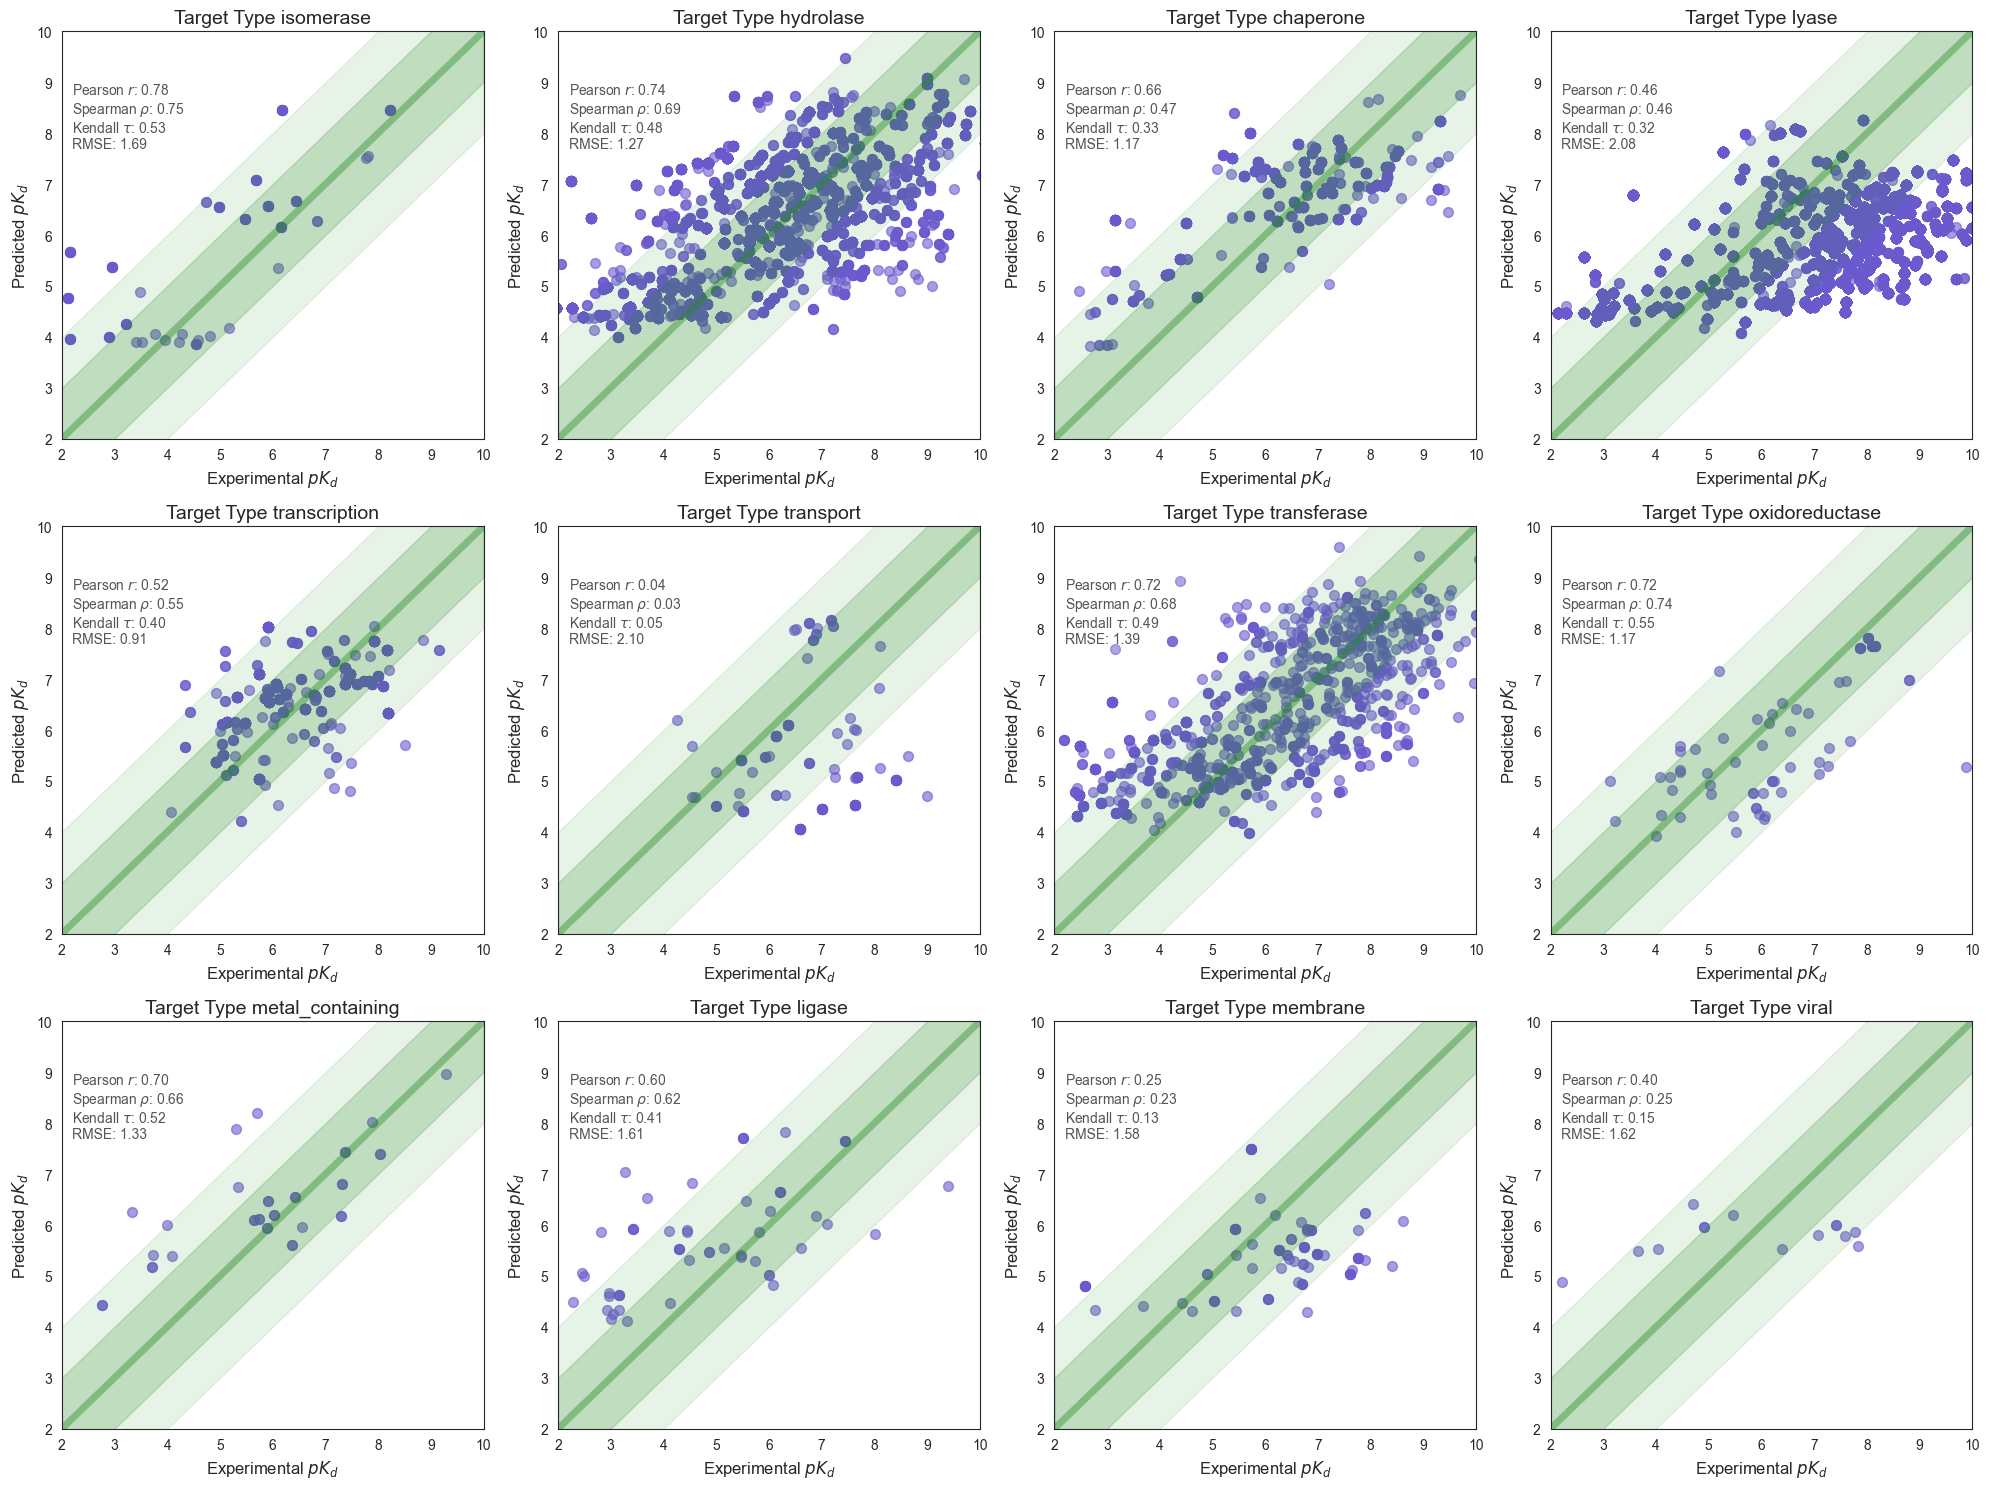

In [42]:
# Now plot for each 'type' column from test set
target_counts_type = merged_data['type'].value_counts()
targets_to_plot_type = target_counts_type[target_counts_type >= 10].index

# Filter data for plotting by type
filtered_data_type = merged_data[merged_data['type'].isin(targets_to_plot_type)]

# Filter data for plotting by type, excluding 'other'
filtered_data_type = merged_data[(merged_data['type'].isin(targets_to_plot_type)) & (merged_data['type'] != 'other')]

# Plot predictions for each target type
unique_targets_type = filtered_data_type['type'].unique()
n_targets_type = len(unique_targets_type)

# Define the number of rows and columns for subplots
n_rows_type = (n_targets_type // n_cols) + (n_targets_type % n_cols > 0)

# Create a figure and subplots for type plots
fig_type, axes_type = plt.subplots(n_rows_type, n_cols, figsize=(20, 5 * n_rows_type))
axes_type = axes_type.flatten()

# Plotting for each target type
for i, target in enumerate(unique_targets_type):
    target_data = filtered_data_type[filtered_data_type['type'] == target]
    ax = axes_type[i]
    
    if len(target_data) < 2:
        pearson_corr, spearman_corr, kendall_corr, rmse = "NA", "NA", "NA", "NA"
    else:
        # Calculate Pearson, Spearman, Kendall correlations
        pearson_corr, _ = pearsonr(target_data['label'], target_data['prediction'])
        spearman_corr, _ = spearmanr(target_data['label'], target_data['prediction'])
        kendall_corr, _ = kendalltau(target_data['label'], target_data['prediction'])

        # Calculate RMSE
        rmse = mean_squared_error(target_data['label'], target_data['prediction'], squared=False)

        # Formatting the values
        pearson_corr = f"{pearson_corr:.2f}"
        spearman_corr = f"{spearman_corr:.2f}"
        kendall_corr = f"{kendall_corr:.2f}"
        rmse = f"{rmse:.2f}"

    # Scatter plot
    ax.scatter(target_data['label'], target_data['prediction'], color='#6A5ACD', alpha=0.6, s=50)  # Slate Blue
    
    # Adding identity line with shaded bands using Forest Green
    x = np.linspace(2, 10, 100)
    y = x
    ax.plot(x, y, color='#228B22', linestyle='-', linewidth=5, alpha=0.4)  # Forest Green line
    ax.fill_between(x, y - 1, y + 1, color='#228B22', alpha=0.2)  # Green shade
    ax.fill_between(x, y - 2, y + 2, color='#228B22', alpha=0.1)  # Light Green shade

    ax.set_xlim(2, 10)
    ax.set_ylim(2, 10)

    # Labels and titles
    ax.set_ylabel(r'Predicted $pK_d$', fontsize=12)
    ax.set_xlabel(r'Experimental $pK_d$', fontsize=12)
    ax.set_title(f'Target Type {target}', fontsize=14)

    # Add text for Pearson, Spearman, Kendall correlations, and RM
        # Add text for Pearson, Spearman, Kendall correlations, and RMSE
    ax.text(2.2, 9.0, 
            f'Pearson $r$: {pearson_corr}\nSpearman $\\rho$: {spearman_corr}\nKendall $\\tau$: {kendall_corr}\nRMSE: {rmse}', 
            fontsize=10, verticalalignment='top', color='#555555',  # Slate Blue for text
            bbox=dict(facecolor='white', alpha=0.1, edgecolor='white'))

# Remove any empty subplots for target type
for j in range(i + 1, len(axes_type)):
    fig_type.delaxes(axes_type[j])

# Adjust layout
plt.tight_layout()

# Save the figure for target types
plt.savefig('plots/LeakyPDB_target_type_10points_new.png', dpi=500)
plt.show()


In [3]:
predictions_file = 'data/LeakyPDB_BALM+PEFT_new.csv'
test_set_file = 'data/test_set_with_uniprot.csv'
docking_data_file = 'data/BALM+Docking_data.csv'

# Load the prediction and test set data
predictions = pd.read_csv(predictions_file)
test_set = pd.read_csv(test_set_file)

# Merge prediction data with test set based on protein sequence
merged_data = pd.merge(predictions, test_set, left_on='protein', right_on='Target', how='left')

# Filter out rows where UniProt ID is null
merged_data = merged_data[~merged_data['UniProt_ID'].isnull()]

# Group by target family type and count unique 'PDB_ID' and 'UniProt_ID'
summary_data = merged_data.groupby('type').agg({
    'PDB_ID': 'nunique',
    'UniProt_ID': 'nunique'
}).reset_index()
summary_data

type  PDB_ID  UniProt_ID
0          chaperone     119           5
1          hydrolase     616          60
2          isomerase      33           9
3             ligase      41           6
4              lyase     409           8
5           membrane      43          10
6   metal_containing      12           6
7              other      69           8
8     oxidoreductase      52          20
9      transcription      93          11
10       transferase     545         112
11         transport      47          13
12             viral      12           7

### LeakyPDB BALM vs Docking

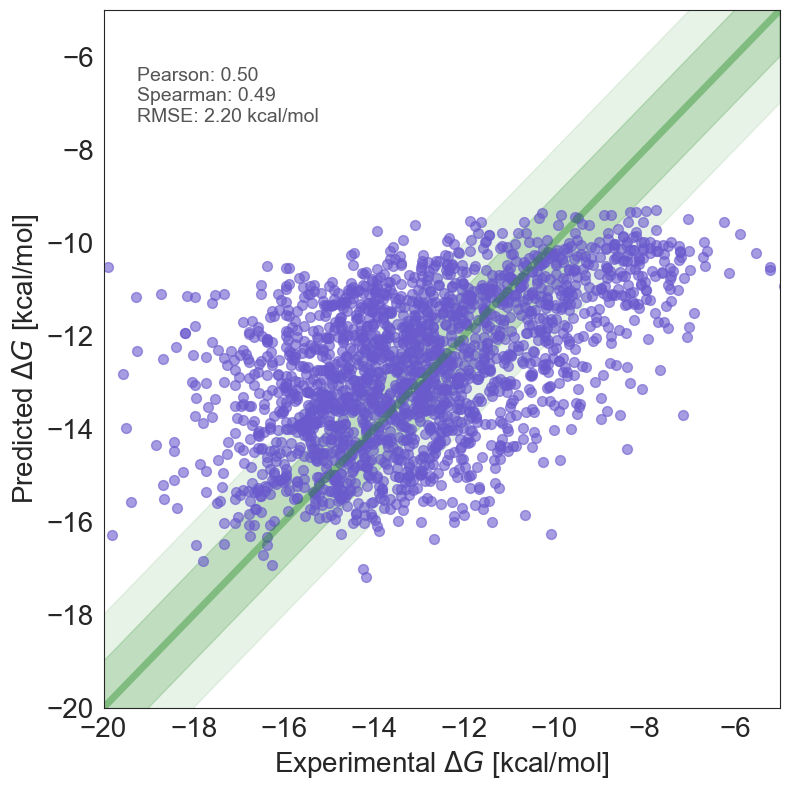

In [27]:
file_path = 'data/BALM+Docking_data.csv'
data = pd.read_csv(file_path)
uncertainty_value = 0.1
data['label_dG'] = data.apply(lambda row: pkd_to_dg(row['Y'],uncertainty_value)[0], axis=1)
#data['prediction_dG'] = data.apply(lambda row: pkd_to_dg(row['prediction'], uncertainty_value)[0], axis=1)
data['prediction_dG'] = data.apply(lambda row: pkd_to_dg(row['prediction'], uncertainty_value)[0], axis=1)
# Randomly select 10% of the data
sampled_data = data.sample(frac=1, random_state=20)

sampled_data= sampled_data.dropna(subset=['label_dG', 'prediction_dG'])
# Calculate Pearson and Spearman correlations
pearson_corr, _ = pearsonr(sampled_data['label_dG'], sampled_data['prediction_dG'])
spearman_corr, _ = spearmanr(sampled_data['label_dG'], sampled_data['prediction_dG'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(sampled_data['label_dG'], sampled_data['prediction_dG']))

# Scatter plot with white background and using the specified colors for shaded bands
sns.set_style("white")

plt.figure(figsize=(8, 8))

# Adding identity line with shaded bands using Forest Green and Slate Blue
x = np.linspace(-20, -5, 100)
y = x
plt.plot(x, y, color='#228B22', linestyle='-', linewidth=5, alpha=0.4)

plt.fill_between(x, y - 1, y + 1, color='#228B22', alpha=0.2)  # Forest Green
plt.fill_between(x, y - 2, y + 2, color='#228B22', alpha=0.1)  

plt.scatter(sampled_data['label_dG'], sampled_data['prediction_dG'], color='#6A5ACD', alpha=0.6, s=50)

plt.xlim(-20, -5)
plt.ylim(-20, -5)


plt.ylabel(r'Predicted $\Delta G$ [kcal/mol]', fontsize=20)
plt.xlabel(r'Experimental $\Delta G$ [kcal/mol]', fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.text(-19.25, -7.5, f'Pearson: {pearson_corr:.2f}\nSpearman: {spearman_corr:.2f}\nRMSE: {rmse:.2f} kcal/mol', 
         fontsize=14, verticalalignment='bottom', color='#555555',  # Slate Blue for text
         bbox=dict(facecolor='white', alpha=0.01, edgecolor='white'))

plt.tight_layout()
plt.show()

### LeakyPDB_BALM+Docking data target family wise

In [12]:


import os
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error
import pandas as pd

# Load and prepare data
file_path = 'data/BALM+Docking_data.csv'
data = pd.read_csv(file_path)

data['rdock SCORE'] = data['rdock SCORE'] / 4.2
data['rdock SCORE.INTER'] = data['rdock SCORE.INTER'] / 4.2
# Apply pKd to ΔG conversion (assuming pkd_to_dg is defined)
data['label_dG'] = data.apply(lambda row: pkd_to_dg(row['Y'], 0.1)[0], axis=1)
data['prediction_dG'] = data.apply(lambda row: pkd_to_dg(row['prediction'], 0.1)[0], axis=1)

# Apply filtering conditions
target_counts_type = data['type'].value_counts()
targets_to_plot_type = target_counts_type[target_counts_type >= 10].index
filtered_data_type = data[(data['type'].isin(targets_to_plot_type)) & (data['type'] != 'other')]

# Remove rows with NaNs or infinite values in the raw columns
filtered_data_type = filtered_data_type.replace([np.inf, -np.inf], np.nan).dropna(
    subset=['label_dG', 'prediction_dG', 'vina dGbind'])



# Plot predictions for each target type
unique_targets_type = filtered_data_type['type'].unique()
n_targets_type = len(unique_targets_type)
n_cols = 4  # Adjust as needed
# Define the number of rows and columns for subplots
n_rows_type = (n_targets_type // n_cols) + (n_targets_type % n_cols > 0)


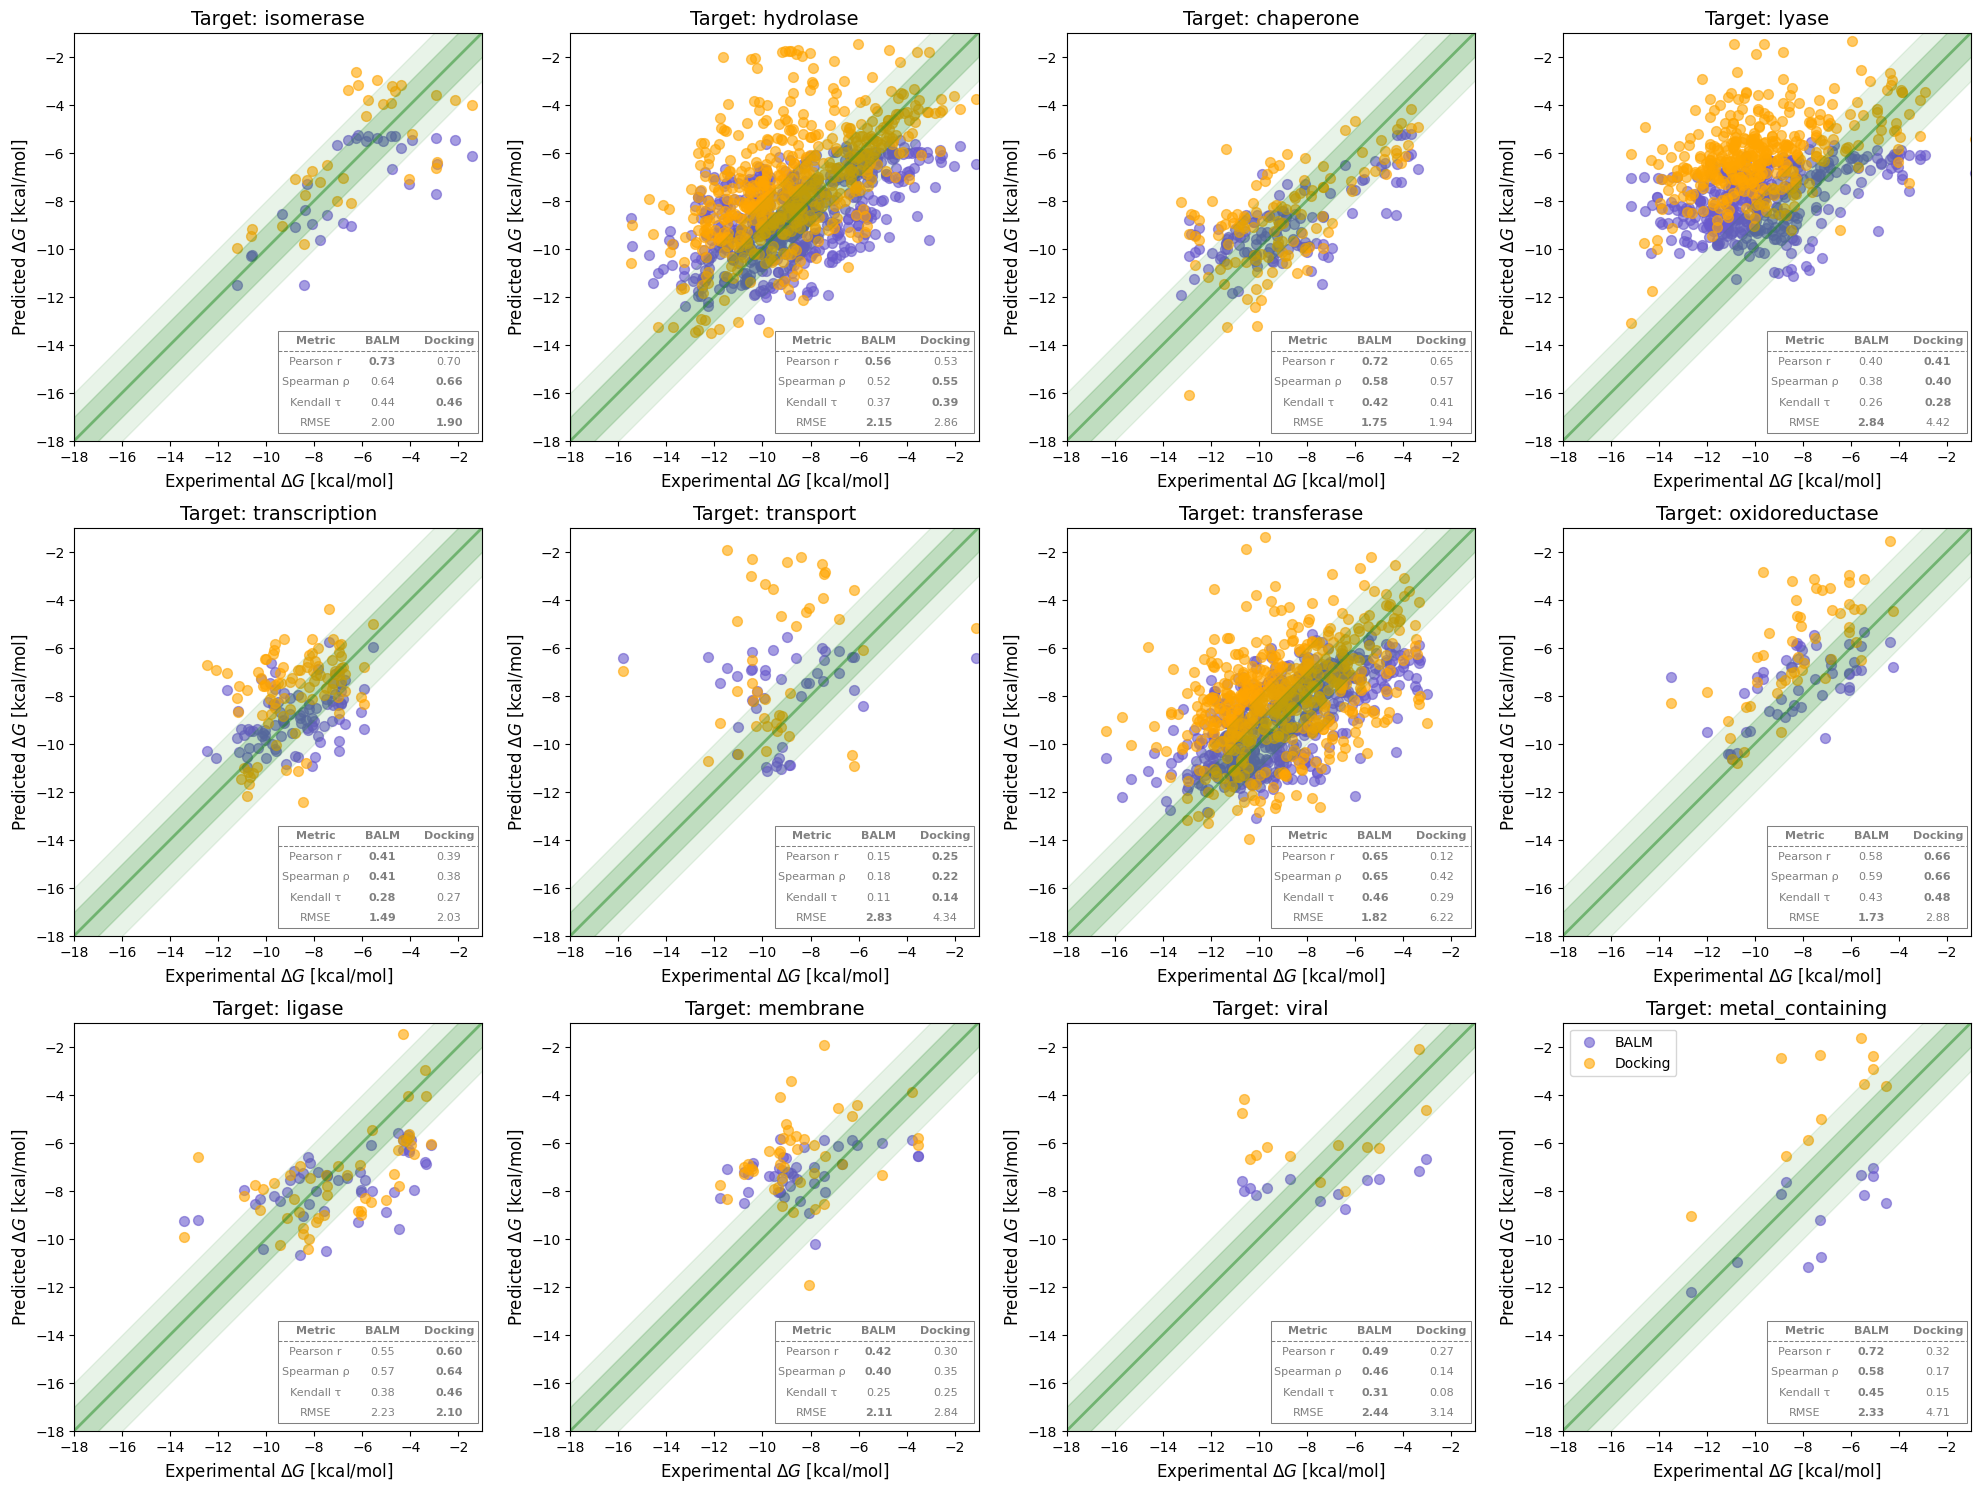

In [18]:

from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error
# Set figure size and square aspect ratio
fig, axes = plt.subplots(n_rows_type, n_cols, figsize=(20, 5 * n_rows_type))
axes = axes.flatten()
font_size = 8  # Font size for compactness
font_color = 'grey'  # Grey color for all font in table
header_font_size = 8  # Smaller font size for headers to fit text fully
table_cell_pad = 0.15  # Reduced padding between cells for a more compact appearance

# Plot for each target type
for i, target in enumerate(unique_targets_type):
    target_data = filtered_data_type[filtered_data_type['type'] == target]
    target_data = target_data.dropna(subset=['label_dG','prediction_dG','vina dGbind'], how='any')
    ax = axes[i]

    # Calculate metrics for BALM and Docking scores
    if len(target_data) > 1:
        pearson_corr_balm, _ = pearsonr(target_data['label_dG'], target_data['prediction_dG'])
        spearman_corr_balm, _ = spearmanr(target_data['label_dG'], target_data['prediction_dG'])
        kendall_corr_balm, _ = kendalltau(target_data['label_dG'], target_data['prediction_dG'])
        rmse_balm = mean_squared_error(target_data['label_dG'], target_data['prediction_dG'], squared=False)
        
        pearson_corr_docking, _ = pearsonr(target_data['label_dG'], target_data['vina dGbind'])
        spearman_corr_docking, _ = spearmanr(target_data['label_dG'], target_data['vina dGbind'])
        kendall_corr_docking, _ = kendalltau(target_data['label_dG'], target_data['vina dGbind'])
        rmse_docking = mean_squared_error(target_data['label_dG'], target_data['vina dGbind'], squared=False)

        # Data for the table with bold styling for the higher value in each row
        table_data = [
            ["Metric", "BALM", "Docking"],
            ["Pearson r", f"{pearson_corr_balm:.2f}", f"{pearson_corr_docking:.2f}"],
            ["Spearman ρ", f"{spearman_corr_balm:.2f}", f"{spearman_corr_docking:.2f}"],
            ["Kendall τ", f"{kendall_corr_balm:.2f}", f"{kendall_corr_docking:.2f}"],
            ["RMSE", f"{rmse_balm:.2f}", f"{rmse_docking:.2f}"]
        ]
    else:
        table_data = [["Metric", "BALM", "Docking"], ["Pearson r", "NA", "NA"], ["Spearman ρ", "NA", "NA"],
                      ["Kendall τ", "NA", "NA"], ["RMSE", "NA", "NA"]]

    # Plot data points
    ax.scatter(target_data['label_dG'], target_data['prediction_dG'], color='#6A5ACD', alpha=0.6, s=50, label='BALM')
    ax.scatter(target_data['label_dG'], target_data['vina dGbind'], color='orange', alpha=0.6, s=50, label='Docking')

    # Identity line
    x = np.linspace(-18, -1, 100)
    ax.plot(x, x, color='#228B22', linestyle='-', linewidth=2, alpha=0.5)
    ax.fill_between(x, x - 1, x + 1, color='#228B22', alpha=0.2)
    ax.fill_between(x, x - 2, x + 2, color='#228B22', alpha=0.1)

    # Set limits, labels, and aspect ratio
    ax.set_xlim(-18, -1)
    ax.set_ylim(-18, -1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_ylabel(r'Predicted $\Delta G$ [kcal/mol]', fontsize=12)
    ax.set_xlabel(r'Experimental $\Delta G$ [kcal/mol]', fontsize=12)
    ax.set_title(f'Target: {target}', fontsize=14)

    # Create the table with a solid line after the header row and an outer border
    table = ax.table(cellText=table_data, cellLoc='center', loc='lower right',bbox=[0.51, 0.02, 0.49, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(font_size)

    # Style table cells
    for (row, col), cell in table.get_celld().items():
        cell.set_text_props(color=font_color, ha='center')
        cell.PAD = table_cell_pad
        cell.set_linewidth(0)  # Remove all inner cell borders initially

        # Bold the header and higher value cells
        if row == 0:
            cell.set_text_props(fontweight='bold', fontsize=header_font_size)
        elif row > 0 and col > 0:
            try:
                # Check RMSE row to bold the lowest RMSE
                if row == 4:  # RMSE row
                    val_balm = float(table_data[row][1])
                    val_docking = float(table_data[row][2])
                    if (col == 1 and val_balm < val_docking) or (col == 2 and val_docking < val_balm):
                        cell.set_text_props(fontweight='bold')
                else:
                    # For other rows, bold the higher value
                    val_balm = float(table_data[row][1])
                    val_docking = float(table_data[row][2])
                    if (col == 1 and val_balm > val_docking) or (col == 2 and val_docking > val_balm):
                        cell.set_text_props(fontweight='bold')
            except ValueError:
                pass  # Ignore non-numeric values

    # Transform bounding box to axis coordinates
    bbox = table.get_window_extent(fig.canvas.get_renderer())
    inv = ax.transAxes.inverted()
    bbox = inv.transform(bbox)
    x0, y0 = bbox[0]
    x1, y1 = bbox[1]

    # Add rectangle around table using axis coordinates
    rect = Rectangle((x0 - 0.01, y0), x1 - x0, y1 - y0, linewidth=0.75, edgecolor='grey', facecolor='none', transform=ax.transAxes)
    ax.add_patch(rect)

    # Calculate the position for the dotted line
    line_y = y0 + (y1 - y0) * 0.8  # Adjust as necessary to place it just below the header row
    line = Line2D([x0 - 0.01, x1-0.01], [line_y, line_y], color='grey', linestyle='--', linewidth=0.75, transform=ax.transAxes)
    ax.add_line(line)
    


# Remove any extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig('plots/Vina_BALM.png',dpi=500)
plt.show()


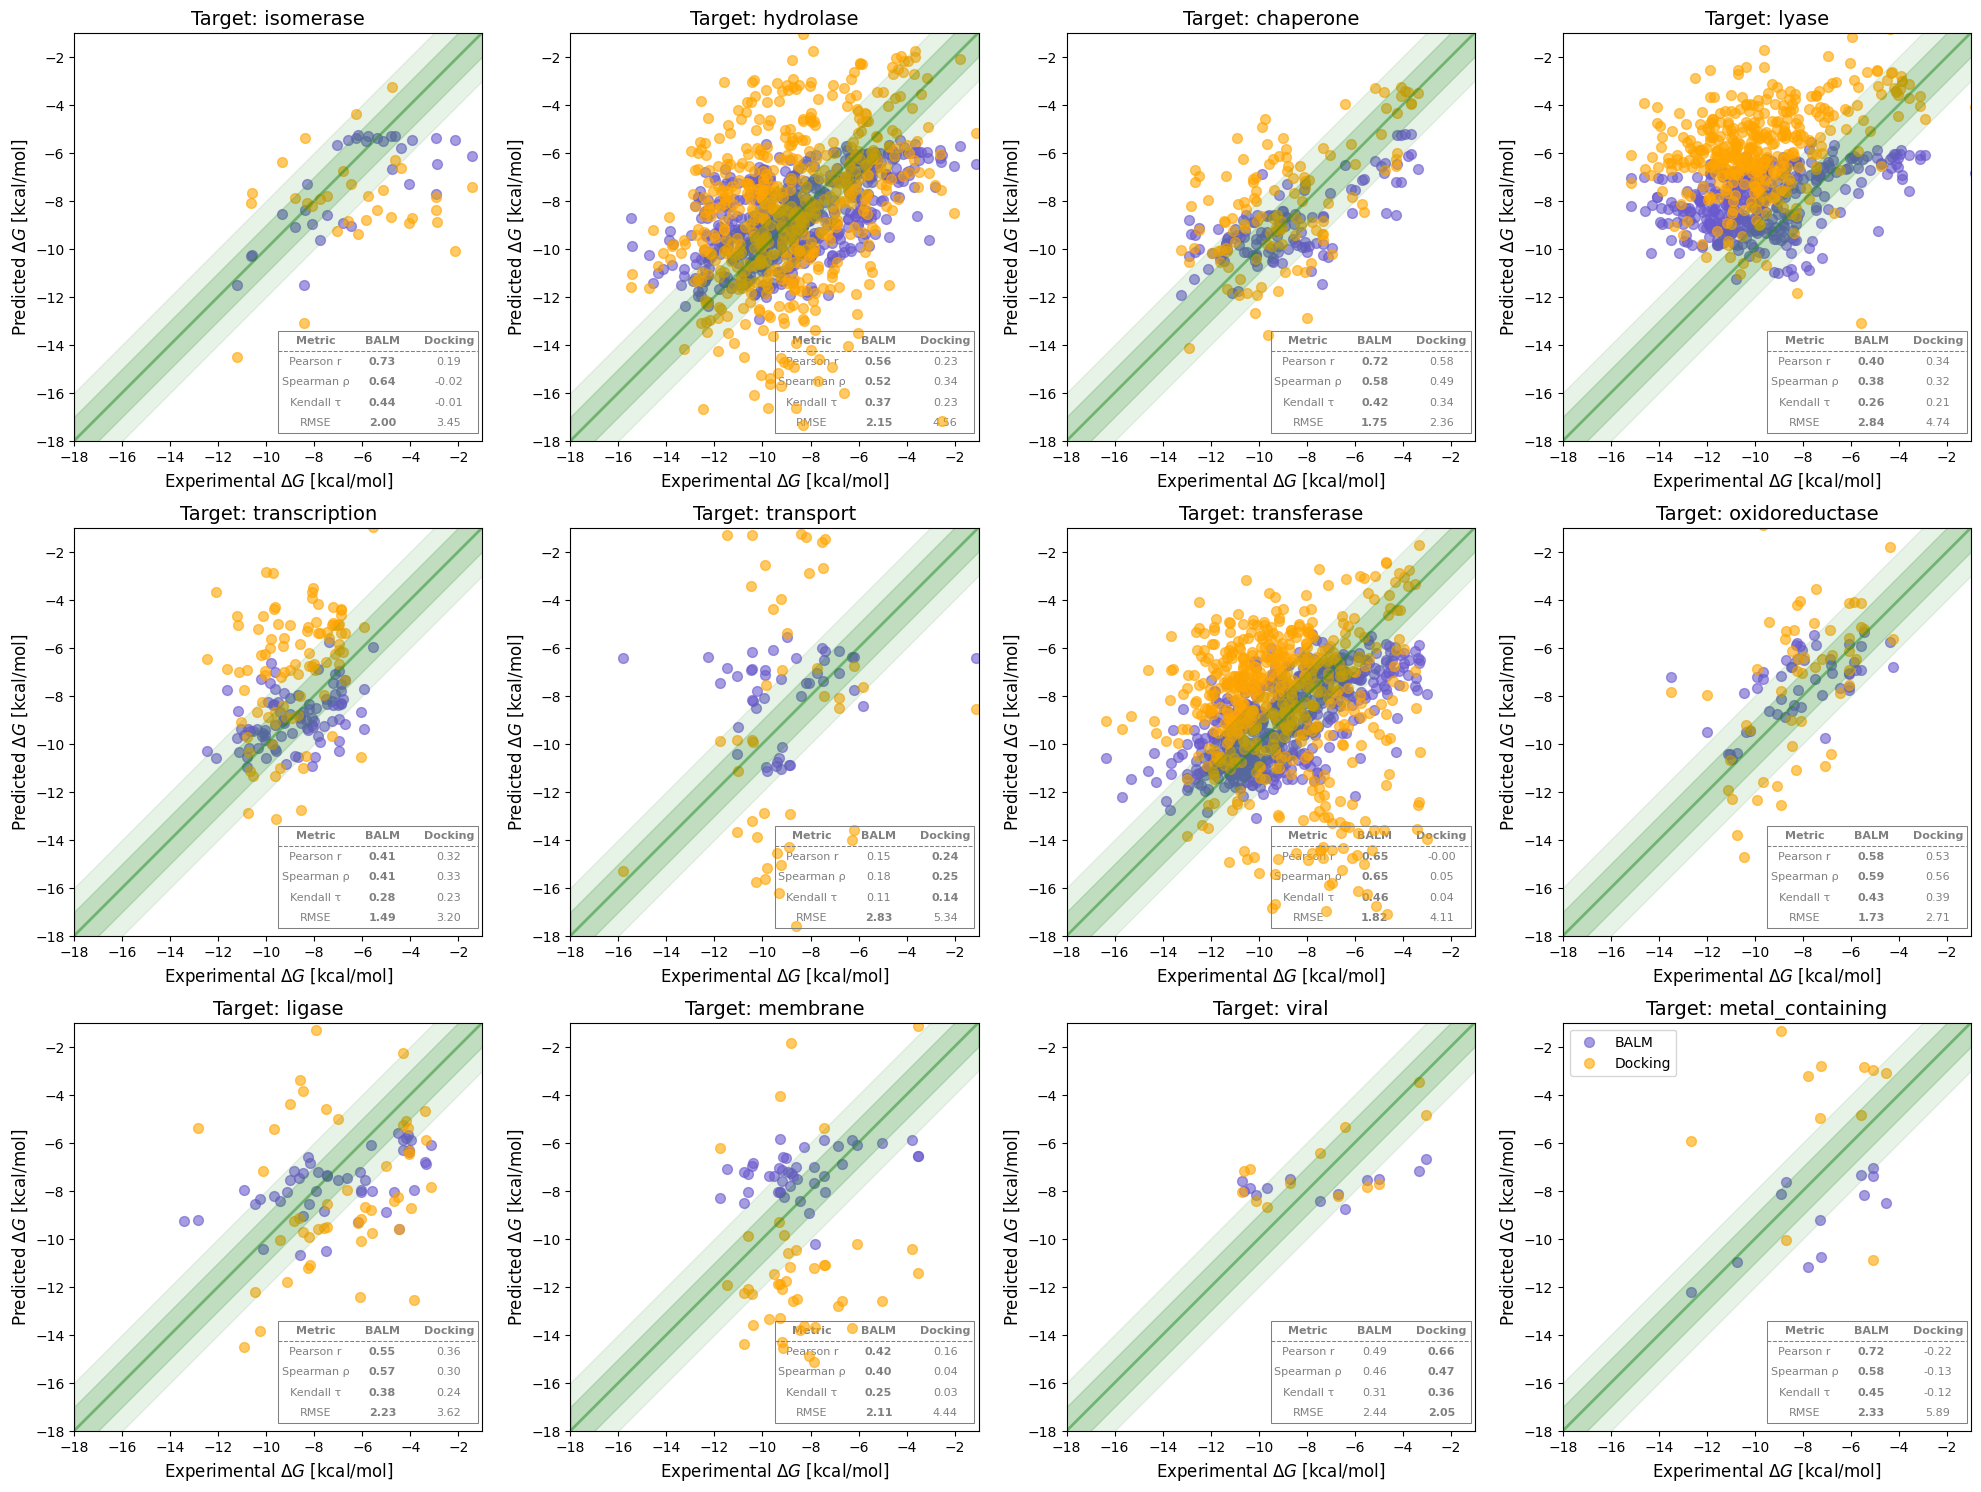

In [16]:

from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error
# Set figure size and square aspect ratio
fig, axes = plt.subplots(n_rows_type, n_cols, figsize=(20, 5 * n_rows_type))
axes = axes.flatten()
font_size = 8  # Font size for compactness
font_color = 'grey'  # Grey color for all font in table
header_font_size = 8  # Smaller font size for headers to fit text fully
table_cell_pad = 0.15  # Reduced padding between cells for a more compact appearance

# Plot for each target type
for i, target in enumerate(unique_targets_type):
    target_data = filtered_data_type[filtered_data_type['type'] == target]
    target_data = target_data.dropna(subset=['label_dG'], how='any')
    ax = axes[i]

    # Calculate metrics for BALM and rDock Docking scores
    if len(target_data) > 1:
        pearson_corr_balm, _ = pearsonr(target_data['label_dG'], target_data['prediction_dG'])
        spearman_corr_balm, _ = spearmanr(target_data['label_dG'], target_data['prediction_dG'])
        kendall_corr_balm, _ = kendalltau(target_data['label_dG'], target_data['prediction_dG'])
        rmse_balm = mean_squared_error(target_data['label_dG'], target_data['prediction_dG'], squared=False)
        
        pearson_corr_docking, _ = pearsonr(target_data['label_dG'], target_data['rdock SCORE'])
        spearman_corr_docking, _ = spearmanr(target_data['label_dG'], target_data['rdock SCORE'])
        kendall_corr_docking, _ = kendalltau(target_data['label_dG'], target_data['rdock SCORE'])
        rmse_docking = mean_squared_error(target_data['label_dG'], target_data['rdock SCORE'], squared=False)

        # Data for the table with bold styling for the higher value in each row
        table_data = [
            ["Metric", "BALM", "Docking"],
            ["Pearson r", f"{pearson_corr_balm:.2f}", f"{pearson_corr_docking:.2f}"],
            ["Spearman ρ", f"{spearman_corr_balm:.2f}", f"{spearman_corr_docking:.2f}"],
            ["Kendall τ", f"{kendall_corr_balm:.2f}", f"{kendall_corr_docking:.2f}"],
            ["RMSE", f"{rmse_balm:.2f}", f"{rmse_docking:.2f}"]
        ]
    else:
        table_data = [["Metric", "BALM", "Docking"], ["Pearson r", "NA", "NA"], ["Spearman ρ", "NA", "NA"],
                      ["Kendall τ", "NA", "NA"], ["RMSE", "NA", "NA"]]

    # Plot data points
    ax.scatter(target_data['label_dG'], target_data['prediction_dG'], color='#6A5ACD', alpha=0.6, s=50, label='BALM')
    ax.scatter(target_data['label_dG'], target_data['rdock SCORE'], color='orange', alpha=0.6, s=50, label='Docking')

    # Identity line
    x = np.linspace(-18, -1, 100)
    ax.plot(x, x, color='#228B22', linestyle='-', linewidth=2, alpha=0.5)
    ax.fill_between(x, x - 1, x + 1, color='#228B22', alpha=0.2)
    ax.fill_between(x, x - 2, x + 2, color='#228B22', alpha=0.1)

    # Set limits, labels, and aspect ratio
    ax.set_xlim(-18, -1)
    ax.set_ylim(-18, -1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_ylabel(r'Predicted $\Delta G$ [kcal/mol]', fontsize=12)
    ax.set_xlabel(r'Experimental $\Delta G$ [kcal/mol]', fontsize=12)
    ax.set_title(f'Target: {target}', fontsize=14)

    # Create the table with a solid line after the header row and an outer border
    table = ax.table(cellText=table_data, cellLoc='center', loc='lower right', bbox=[0.51, 0.02, 0.49, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(font_size)

    # Style table cells
    for (row, col), cell in table.get_celld().items():
        cell.set_text_props(color=font_color, ha='center')
        cell.PAD = table_cell_pad
        cell.set_linewidth(0)  # Remove all inner cell borders initially

        # Bold the header and higher value cells
        if row == 0:
            cell.set_text_props(fontweight='bold', fontsize=header_font_size)
        elif row > 0 and col > 0:
            try:
                # Check RMSE row to bold the lowest RMSE
                if row == 4:  # RMSE row
                    val_balm = float(table_data[row][1])
                    val_docking = float(table_data[row][2])
                    if (col == 1 and val_balm < val_docking) or (col == 2 and val_docking < val_balm):
                        cell.set_text_props(fontweight='bold')
                else:
                    # For other rows, bold the higher value
                    val_balm = float(table_data[row][1])
                    val_docking = float(table_data[row][2])
                    if (col == 1 and val_balm > val_docking) or (col == 2 and val_docking > val_balm):
                        cell.set_text_props(fontweight='bold')
            except ValueError:
                pass  # Ignore non-numeric values

    # Transform bounding box to axis coordinates
    bbox = table.get_window_extent(fig.canvas.get_renderer())
    inv = ax.transAxes.inverted()
    bbox = inv.transform(bbox)
    x0, y0 = bbox[0]
    x1, y1 = bbox[1]

    # Add rectangle around table using axis coordinates
    rect = Rectangle((x0 - 0.01, y0), x1 - x0, y1 - y0, linewidth=0.75, edgecolor='grey', facecolor='none', transform=ax.transAxes)
    ax.add_patch(rect)

    # Calculate the position for the dotted line
    line_y = y0 + (y1 - y0) * 0.8  # Adjust as necessary to place it just below the header row
    line = Line2D([x0 - 0.01, x1-0.01], [line_y, line_y], color='grey', linestyle='--', linewidth=0.75, transform=ax.transAxes)
    ax.add_line(line)
    


# Remove any extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig('plots/RDock_BALM.png',dpi=500)
plt.show()


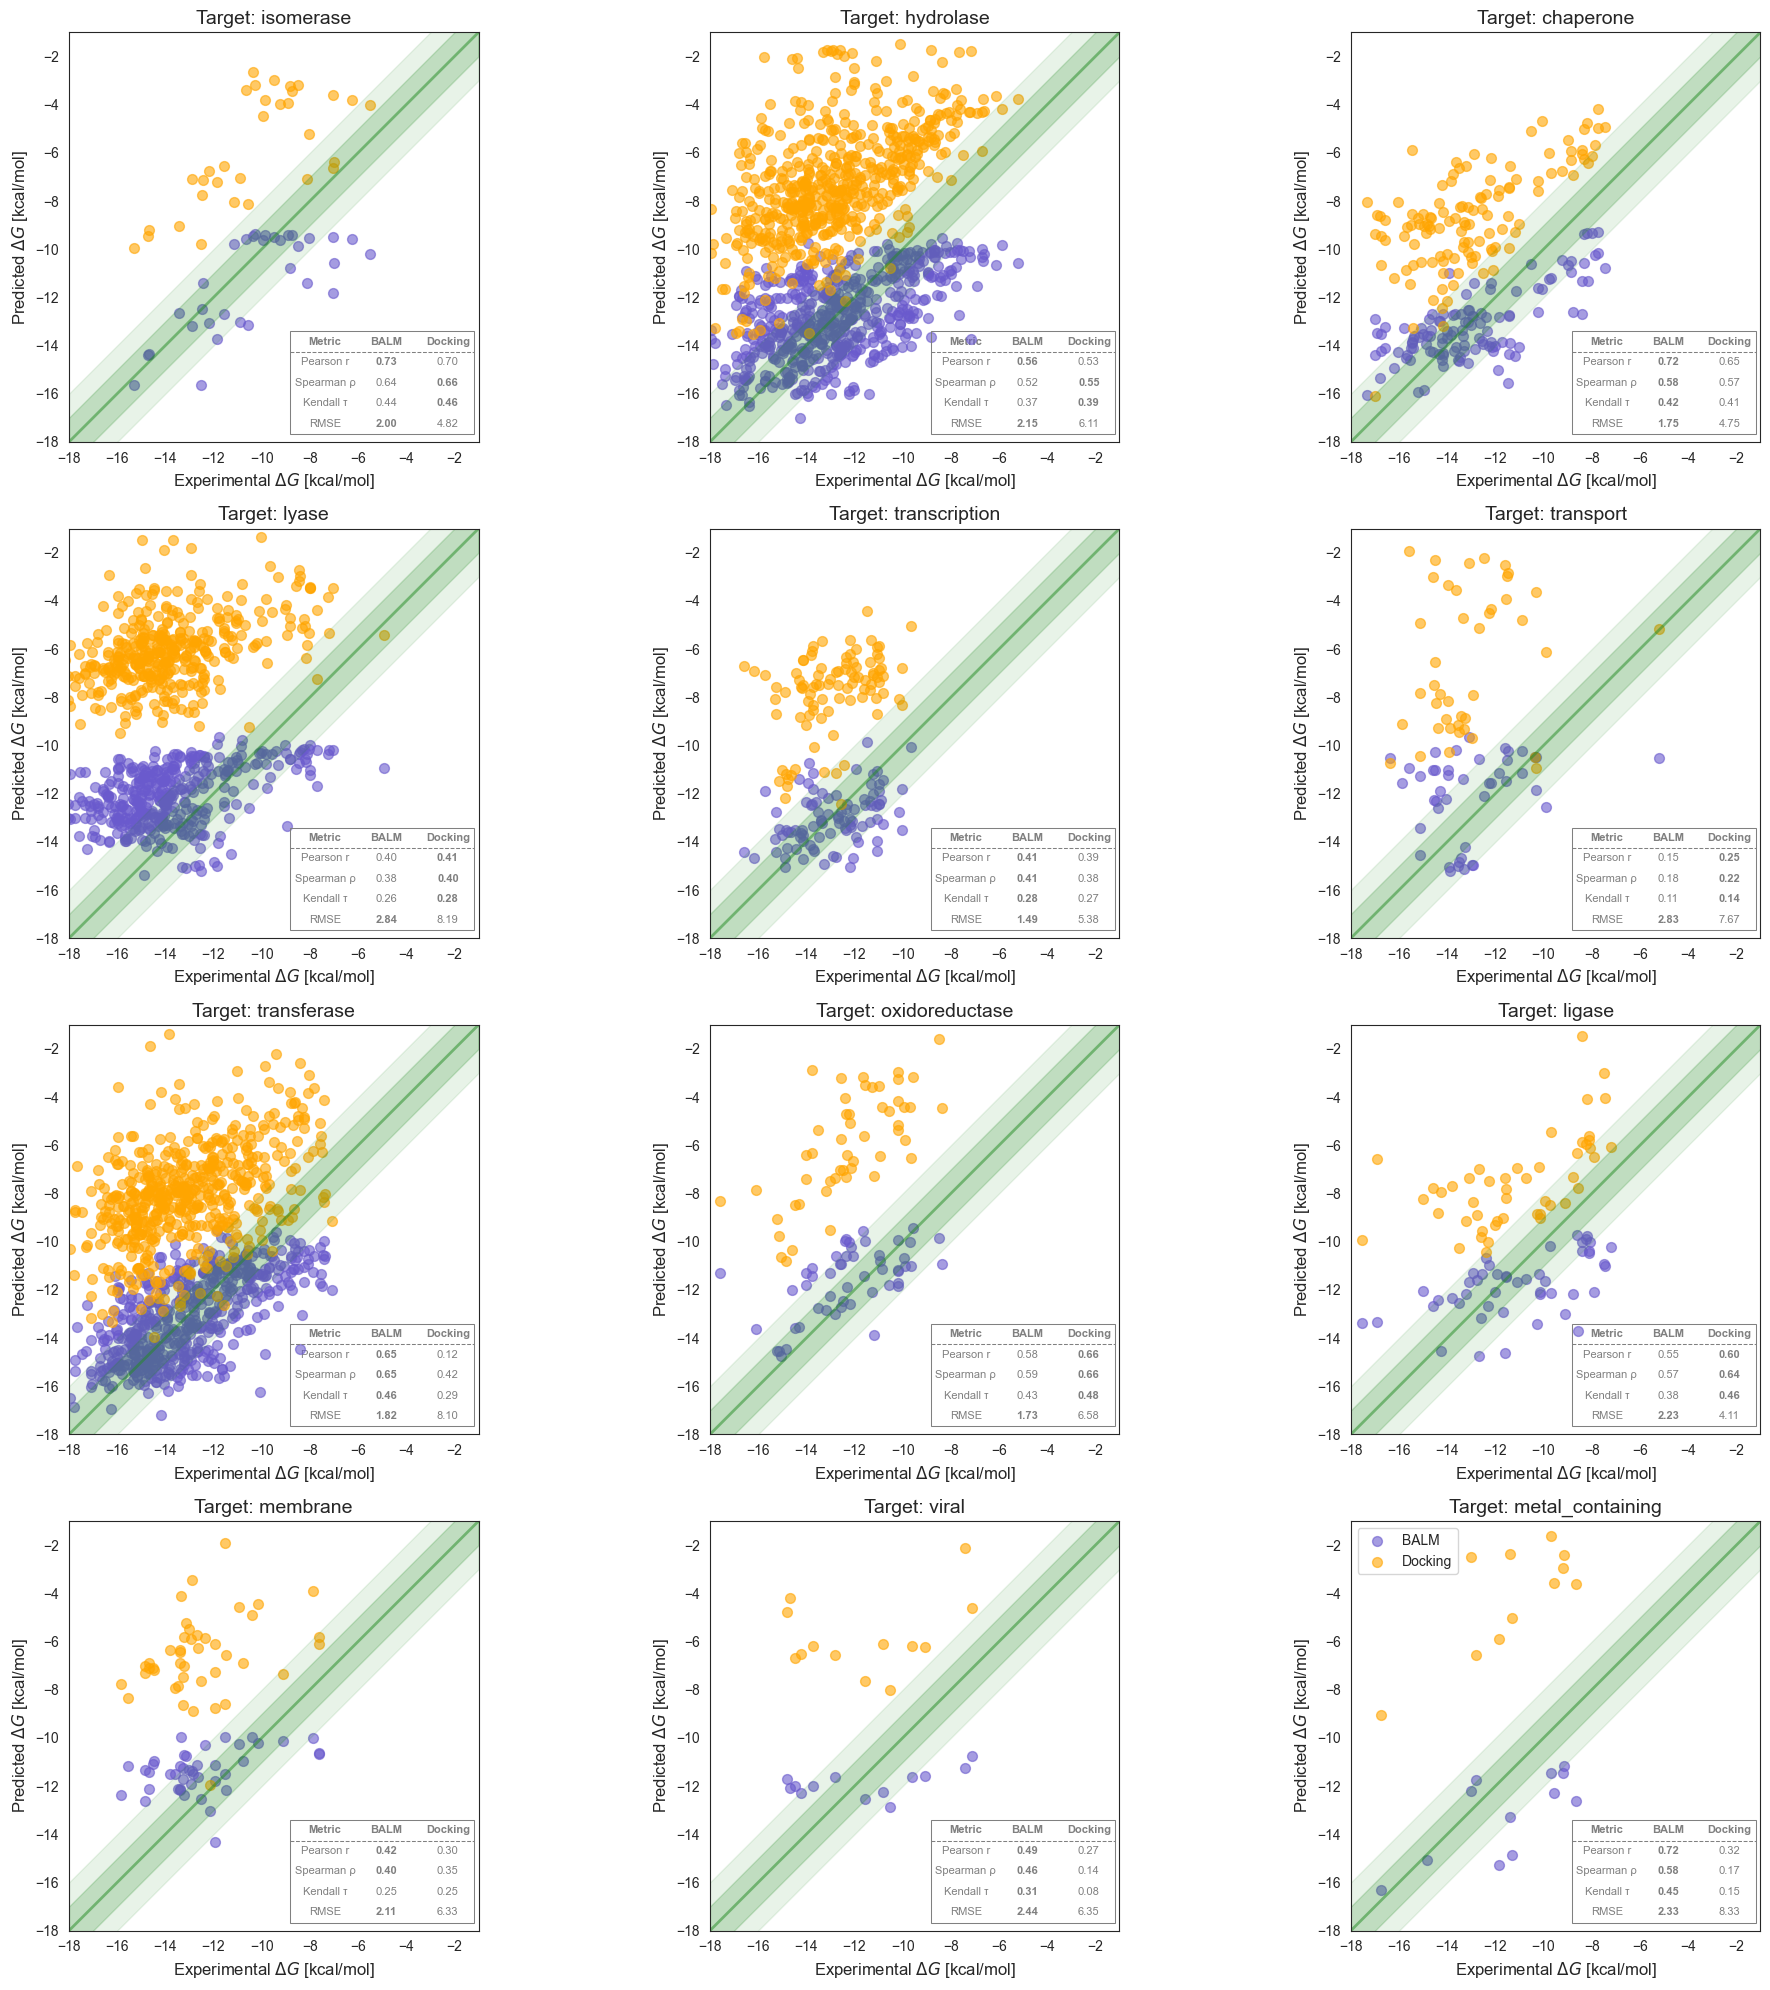

In [30]:

from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error
# Set figure size and square aspect ratio
fig, axes = plt.subplots(n_rows_type, n_cols, figsize=(20, 5 * n_rows_type))
axes = axes.flatten()
font_size = 8  # Font size for compactness
font_color = 'grey'  # Grey color for all font in table
header_font_size = 8  # Smaller font size for headers to fit text fully
table_cell_pad = 0.15  # Reduced padding between cells for a more compact appearance

# Plot for each target type
for i, target in enumerate(unique_targets_type):
    target_data = filtered_data_type[filtered_data_type['type'] == target]
    target_data = target_data.dropna(subset=['label_dG','prediction_dG','vina dGbind'], how='any')
    ax = axes[i]

    # Calculate metrics for BALM and Docking scores
    if len(target_data) > 1:
        pearson_corr_balm, _ = pearsonr(target_data['label_dG'], target_data['prediction_dG'])
        spearman_corr_balm, _ = spearmanr(target_data['label_dG'], target_data['prediction_dG'])
        kendall_corr_balm, _ = kendalltau(target_data['label_dG'], target_data['prediction_dG'])
        rmse_balm = mean_squared_error(target_data['label_dG'], target_data['prediction_dG'], squared=False)
        
        pearson_corr_docking, _ = pearsonr(target_data['label_dG'], target_data['vina dGbind'])
        spearman_corr_docking, _ = spearmanr(target_data['label_dG'], target_data['vina dGbind'])
        kendall_corr_docking, _ = kendalltau(target_data['label_dG'], target_data['vina dGbind'])
        rmse_docking = mean_squared_error(target_data['label_dG'], target_data['vina dGbind'], squared=False)

        # Data for the table with bold styling for the higher value in each row
        table_data = [
            ["Metric", "BALM", "Docking"],
            ["Pearson r", f"{pearson_corr_balm:.2f}", f"{pearson_corr_docking:.2f}"],
            ["Spearman ρ", f"{spearman_corr_balm:.2f}", f"{spearman_corr_docking:.2f}"],
            ["Kendall τ", f"{kendall_corr_balm:.2f}", f"{kendall_corr_docking:.2f}"],
            ["RMSE", f"{rmse_balm:.2f}", f"{rmse_docking:.2f}"]
        ]
    else:
        table_data = [["Metric", "BALM", "Docking"], ["Pearson r", "NA", "NA"], ["Spearman ρ", "NA", "NA"],
                      ["Kendall τ", "NA", "NA"], ["RMSE", "NA", "NA"]]

    # Plot data points
    ax.scatter(target_data['label_dG'], target_data['prediction_dG'], color='#6A5ACD', alpha=0.6, s=50, label='BALM')
    ax.scatter(target_data['label_dG'], target_data['vina dGbind'], color='orange', alpha=0.6, s=50, label='Docking')

    # Identity line
    x = np.linspace(-18, -1, 100)
    ax.plot(x, x, color='#228B22', linestyle='-', linewidth=2, alpha=0.5)
    ax.fill_between(x, x - 1, x + 1, color='#228B22', alpha=0.2)
    ax.fill_between(x, x - 2, x + 2, color='#228B22', alpha=0.1)

    # Set limits, labels, and aspect ratio
    ax.set_xlim(-18, -1)
    ax.set_ylim(-18, -1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_ylabel(r'Predicted $\Delta G$ [kcal/mol]', fontsize=12)
    ax.set_xlabel(r'Experimental $\Delta G$ [kcal/mol]', fontsize=12)
    ax.set_title(f'Target: {target}', fontsize=14)

    # Create the table with a solid line after the header row and an outer border
    table = ax.table(cellText=table_data, cellLoc='center', loc='lower right', bbox=[0.55, 0.02, 0.45, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(font_size)

    # Style table cells
    for (row, col), cell in table.get_celld().items():
        cell.set_text_props(color=font_color, ha='center')
        cell.PAD = table_cell_pad
        cell.set_linewidth(0)  # Remove all inner cell borders initially

        # Bold the header and higher value cells
        if row == 0:
            cell.set_text_props(fontweight='bold', fontsize=header_font_size)
        elif row > 0 and col > 0:
            try:
                # Check RMSE row to bold the lowest RMSE
                if row == 4:  # RMSE row
                    val_balm = float(table_data[row][1])
                    val_docking = float(table_data[row][2])
                    if (col == 1 and val_balm < val_docking) or (col == 2 and val_docking < val_balm):
                        cell.set_text_props(fontweight='bold')
                else:
                    # For other rows, bold the higher value
                    val_balm = float(table_data[row][1])
                    val_docking = float(table_data[row][2])
                    if (col == 1 and val_balm > val_docking) or (col == 2 and val_docking > val_balm):
                        cell.set_text_props(fontweight='bold')
            except ValueError:
                pass  # Ignore non-numeric values

    # Transform bounding box to axis coordinates
    bbox = table.get_window_extent(fig.canvas.get_renderer())
    inv = ax.transAxes.inverted()
    bbox = inv.transform(bbox)
    x0, y0 = bbox[0]
    x1, y1 = bbox[1]

    # Add rectangle around table using axis coordinates
    rect = Rectangle((x0 - 0.01, y0), x1 - x0, y1 - y0, linewidth=0.75, edgecolor='grey', facecolor='none', transform=ax.transAxes)
    ax.add_patch(rect)

    # Calculate the position for the dotted line
    line_y = y0 + (y1 - y0) * 0.8  # Adjust as necessary to place it just below the header row
    line = Line2D([x0 - 0.01, x1-0.01], [line_y, line_y], color='grey', linestyle='--', linewidth=0.75, transform=ax.transAxes)
    ax.add_line(line)
    


# Remove any extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show
plt.tight_layout()
plt.legend(loc='upper left')
plt.show()


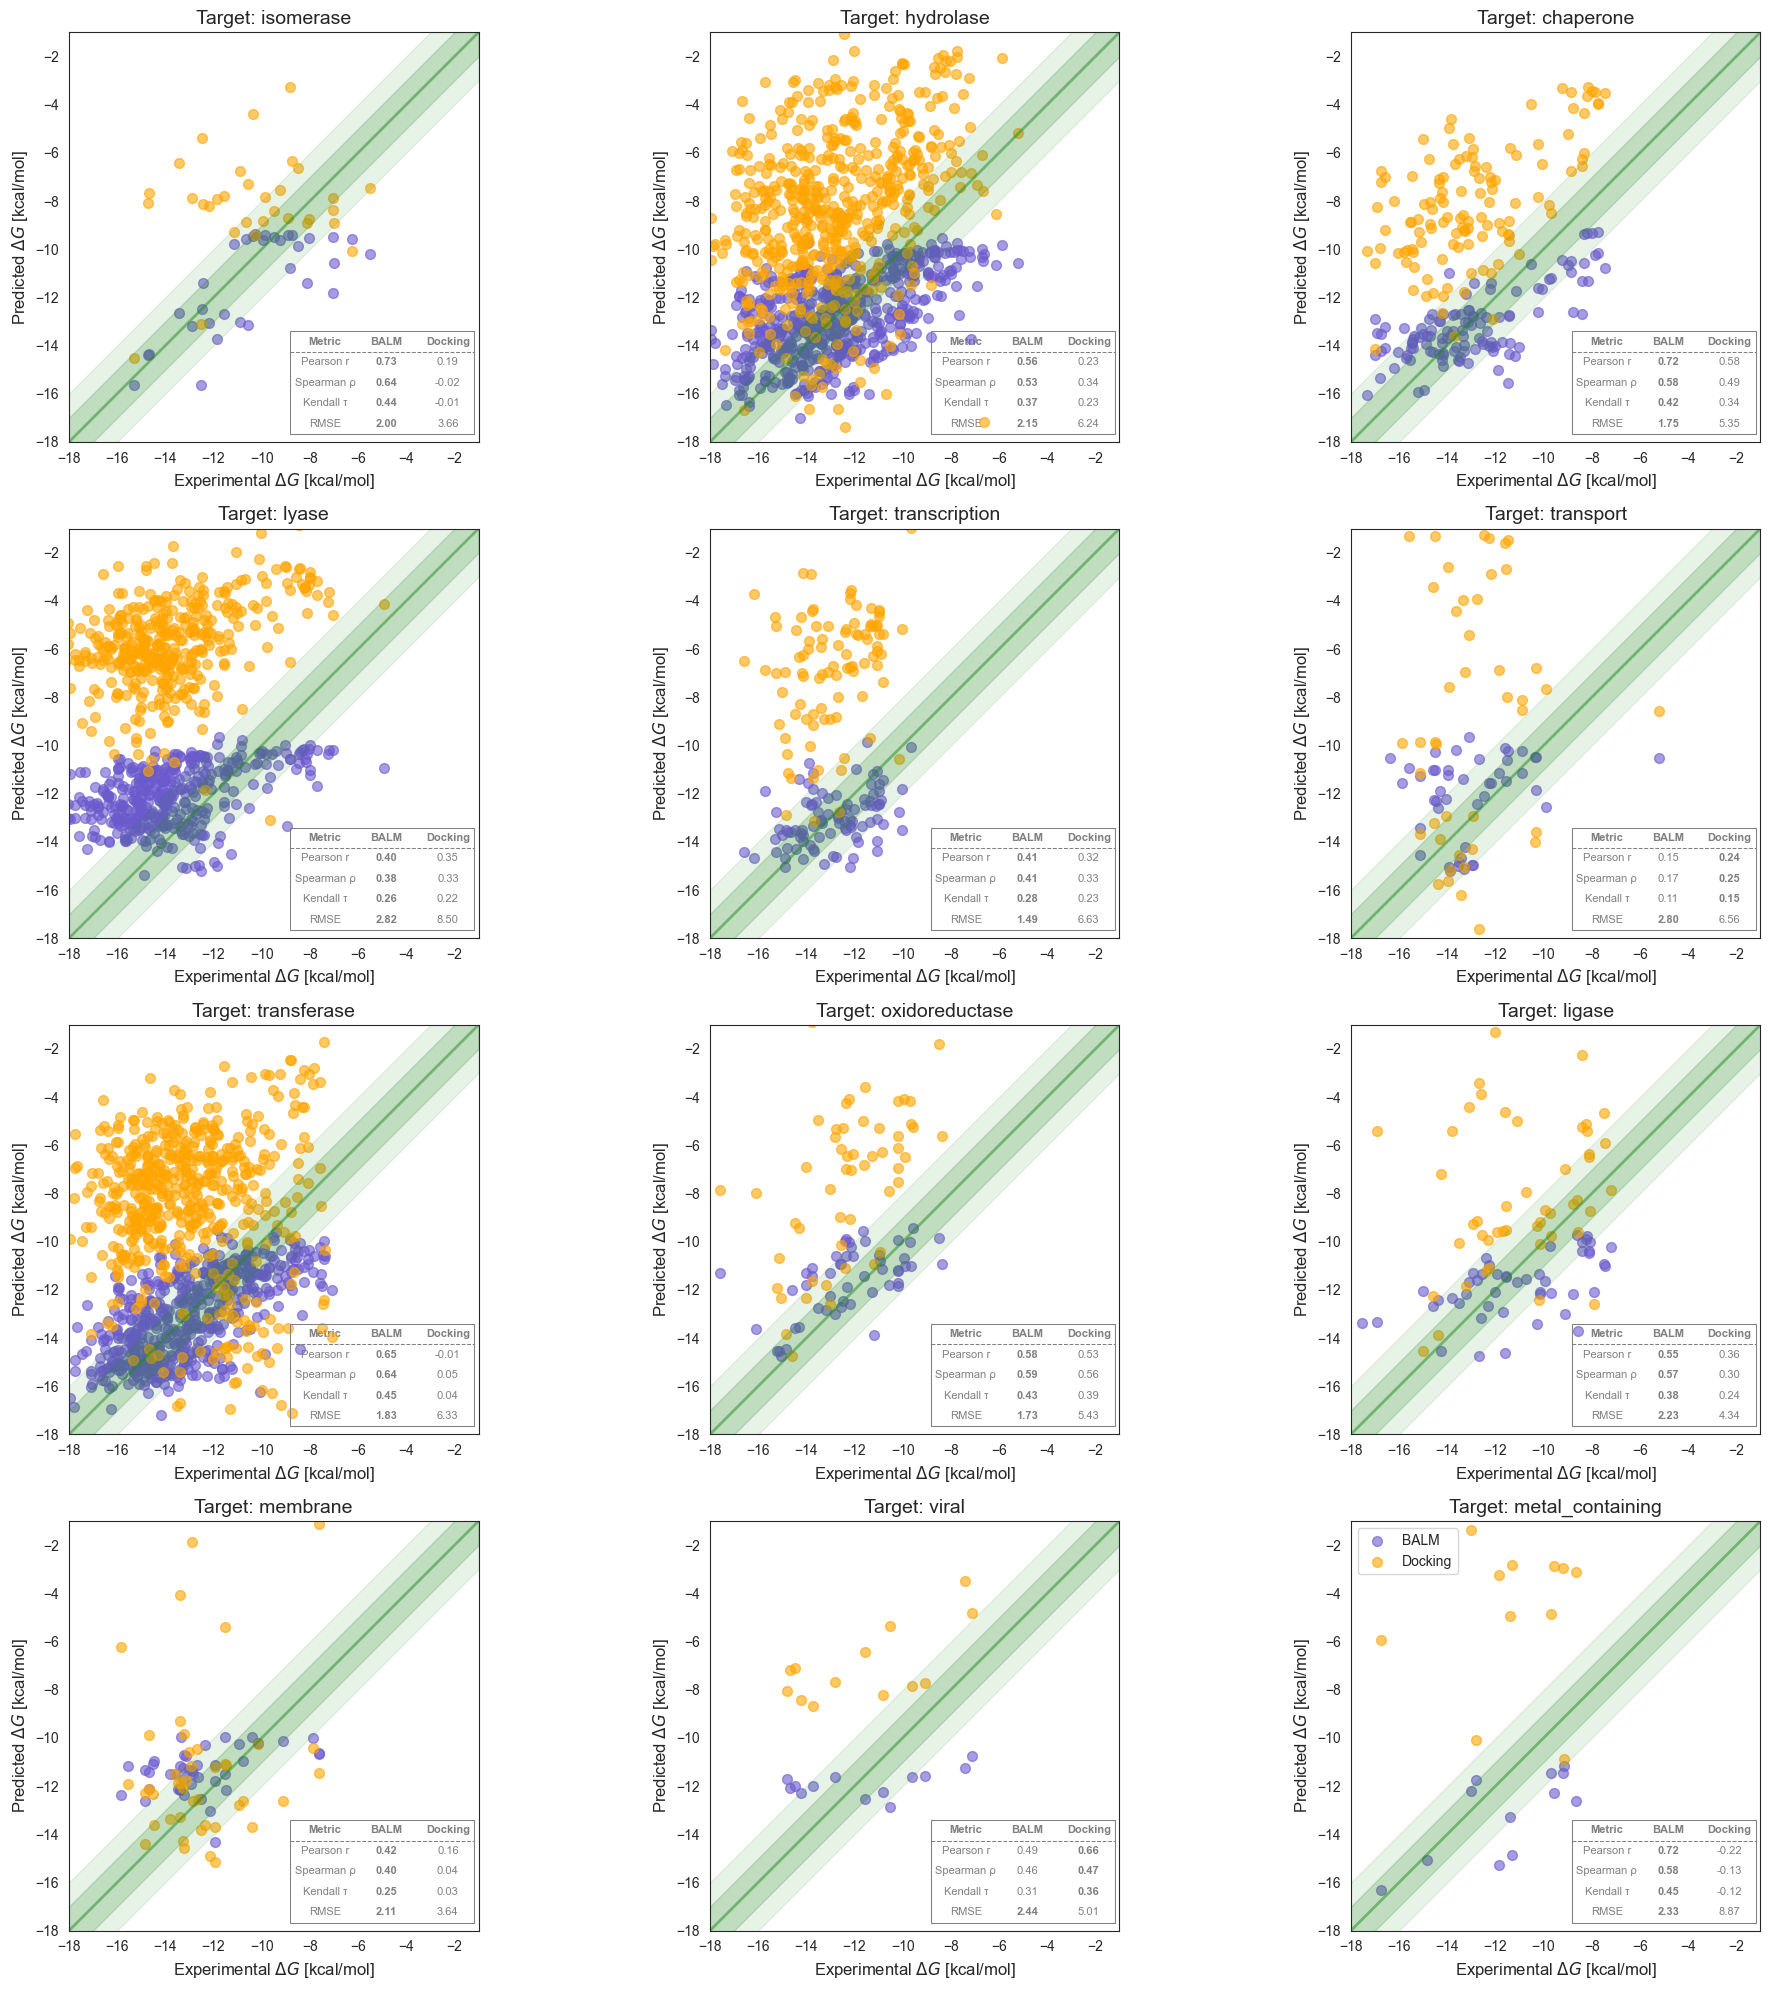

In [25]:

from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error
# Set figure size and square aspect ratio
fig, axes = plt.subplots(n_rows_type, n_cols, figsize=(20, 5 * n_rows_type))
axes = axes.flatten()
font_size = 8  # Font size for compactness
font_color = 'grey'  # Grey color for all font in table
header_font_size = 8  # Smaller font size for headers to fit text fully
table_cell_pad = 0.15  # Reduced padding between cells for a more compact appearance

# Plot for each target type
for i, target in enumerate(unique_targets_type):
    target_data = filtered_data_type[filtered_data_type['type'] == target]
    target_data = target_data.dropna(subset=['label_dG'], how='any')
    ax = axes[i]

    # Calculate metrics for BALM and Docking scores
    if len(target_data) > 1:
        pearson_corr_balm, _ = pearsonr(target_data['label_dG'], target_data['prediction_dG'])
        spearman_corr_balm, _ = spearmanr(target_data['label_dG'], target_data['prediction_dG'])
        kendall_corr_balm, _ = kendalltau(target_data['label_dG'], target_data['prediction_dG'])
        rmse_balm = mean_squared_error(target_data['label_dG'], target_data['prediction_dG'], squared=False)
        
        pearson_corr_docking, _ = pearsonr(target_data['label_dG'], target_data['rdock SCORE'])
        spearman_corr_docking, _ = spearmanr(target_data['label_dG'], target_data['rdock SCORE'])
        kendall_corr_docking, _ = kendalltau(target_data['label_dG'], target_data['rdock SCORE'])
        rmse_docking = mean_squared_error(target_data['label_dG'], target_data['rdock SCORE'], squared=False)

        # Data for the table with bold styling for the higher value in each row
        table_data = [
            ["Metric", "BALM", "Docking"],
            ["Pearson r", f"{pearson_corr_balm:.2f}", f"{pearson_corr_docking:.2f}"],
            ["Spearman ρ", f"{spearman_corr_balm:.2f}", f"{spearman_corr_docking:.2f}"],
            ["Kendall τ", f"{kendall_corr_balm:.2f}", f"{kendall_corr_docking:.2f}"],
            ["RMSE", f"{rmse_balm:.2f}", f"{rmse_docking:.2f}"]
        ]
    else:
        table_data = [["Metric", "BALM", "Docking"], ["Pearson r", "NA", "NA"], ["Spearman ρ", "NA", "NA"],
                      ["Kendall τ", "NA", "NA"], ["RMSE", "NA", "NA"]]

    # Plot data points
    ax.scatter(target_data['label_dG'], target_data['prediction_dG'], color='#6A5ACD', alpha=0.6, s=50, label='BALM')
    ax.scatter(target_data['label_dG'], target_data['rdock SCORE'], color='orange', alpha=0.6, s=50, label='Docking')

    # Identity line
    x = np.linspace(-18, -1, 100)
    ax.plot(x, x, color='#228B22', linestyle='-', linewidth=2, alpha=0.5)
    ax.fill_between(x, x - 1, x + 1, color='#228B22', alpha=0.2)
    ax.fill_between(x, x - 2, x + 2, color='#228B22', alpha=0.1)

    # Set limits, labels, and aspect ratio
    ax.set_xlim(-18, -1)
    ax.set_ylim(-18, -1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_ylabel(r'Predicted $\Delta G$ [kcal/mol]', fontsize=12)
    ax.set_xlabel(r'Experimental $\Delta G$ [kcal/mol]', fontsize=12)
    ax.set_title(f'Target: {target}', fontsize=14)

    # Create the table with a solid line after the header row and an outer border
    table = ax.table(cellText=table_data, cellLoc='center', loc='lower right', bbox=[0.55, 0.02, 0.45, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(font_size)

    # Style table cells
    for (row, col), cell in table.get_celld().items():
        cell.set_text_props(color=font_color, ha='center')
        cell.PAD = table_cell_pad
        cell.set_linewidth(0)  # Remove all inner cell borders initially

        # Bold the header and higher value cells
        if row == 0:
            cell.set_text_props(fontweight='bold', fontsize=header_font_size)
        elif row > 0 and col > 0:
            try:
                # Check RMSE row to bold the lowest RMSE
                if row == 4:  # RMSE row
                    val_balm = float(table_data[row][1])
                    val_docking = float(table_data[row][2])
                    if (col == 1 and val_balm < val_docking) or (col == 2 and val_docking < val_balm):
                        cell.set_text_props(fontweight='bold')
                else:
                    # For other rows, bold the higher value
                    val_balm = float(table_data[row][1])
                    val_docking = float(table_data[row][2])
                    if (col == 1 and val_balm > val_docking) or (col == 2 and val_docking > val_balm):
                        cell.set_text_props(fontweight='bold')
            except ValueError:
                pass  # Ignore non-numeric values

    # Transform bounding box to axis coordinates
    bbox = table.get_window_extent(fig.canvas.get_renderer())
    inv = ax.transAxes.inverted()
    bbox = inv.transform(bbox)
    x0, y0 = bbox[0]
    x1, y1 = bbox[1]

    # Add rectangle around table using axis coordinates
    rect = Rectangle((x0 - 0.01, y0), x1 - x0, y1 - y0, linewidth=0.75, edgecolor='grey', facecolor='none', transform=ax.transAxes)
    ax.add_patch(rect)

    # Calculate the position for the dotted line
    line_y = y0 + (y1 - y0) * 0.8  # Adjust as necessary to place it just below the header row
    line = Line2D([x0 - 0.01, x1-0.01], [line_y, line_y], color='grey', linestyle='--', linewidth=0.75, transform=ax.transAxes)
    ax.add_line(line)
    


# Remove any extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show
plt.tight_layout()
plt.legend(loc='upper left')
plt.show()


In [28]:
### save each subplot separately

import os
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error
import pandas as pd

# Load and prepare data
file_path = 'data/BALM+Dcoking_data.csv'
data = pd.read_csv(file_path)

# Apply pKd to ΔG conversion (assuming pkd_to_dg is defined)
data['label_dG'] = data.apply(lambda row: pkd_to_dg(row['Y'], 0.1)[0], axis=1)
data['prediction_dG'] = data.apply(lambda row: pkd_to_dg(row['prediction'], 0.1)[0], axis=1)

# Apply filtering conditions
target_counts_type = data['type'].value_counts()
targets_to_plot_type = target_counts_type[target_counts_type >= 10].index
filtered_data_type = data[(data['type'].isin(targets_to_plot_type)) & (data['type'] != 'other')]

# Remove rows with NaNs or infinite values in the raw columns
filtered_data_type = filtered_data_type.replace([np.inf, -np.inf], np.nan).dropna(
    subset=['label_dG', 'prediction_dG', 'vina dGbind'])

# Disable LaTeX (since it requires external installation)
plt.rcParams['text.usetex'] = False

# Create output folder
output_folder = "plots/plots_BALM_Vina"
os.makedirs(output_folder, exist_ok=True)

# Plot for each target type individually
font_size = 8  # Font size for compactness
font_color = 'grey'  # Grey color for all font in table
header_font_size = 8  # Smaller font size for headers to fit text fully
table_cell_pad = 0.15  # Reduced padding between cells for a more compact appearance

for target in filtered_data_type['type'].unique():
    target_data = filtered_data_type[filtered_data_type['type'] == target]
    target_data = target_data.dropna(subset=['label_dG'], how='any')

    # Create a new figure for each target
    fig, ax = plt.subplots(figsize=(8, 6))

    # Calculate metrics for BALM and Docking scores
    if len(target_data) > 1:
        pearson_corr_balm, _ = pearsonr(target_data['label_dG'], target_data['prediction_dG'])
        spearman_corr_balm, _ = spearmanr(target_data['label_dG'], target_data['prediction_dG'])
        kendall_corr_balm, _ = kendalltau(target_data['label_dG'], target_data['prediction_dG'])
        rmse_balm = mean_squared_error(target_data['label_dG'], target_data['prediction_dG'], squared=False)
        
        pearson_corr_docking, _ = pearsonr(target_data['label_dG'], target_data['vina dGbind'])
        spearman_corr_docking, _ = spearmanr(target_data['label_dG'], target_data['vina dGbind'])
        kendall_corr_docking, _ = kendalltau(target_data['label_dG'], target_data['vina dGbind'])
        rmse_docking = mean_squared_error(target_data['label_dG'], target_data['vina dGbind'], squared=False)

        # Data for the table with bold styling for the higher value in each row
        table_data = [
            ["Metric", "BALM", "Docking"],
            ["Pearson r", f"{pearson_corr_balm:.2f}", f"{pearson_corr_docking:.2f}"],
            ["Spearman ρ", f"{spearman_corr_balm:.2f}", f"{spearman_corr_docking:.2f}"],
            ["Kendall τ", f"{kendall_corr_balm:.2f}", f"{kendall_corr_docking:.2f}"],
            ["RMSE", f"{rmse_balm:.2f}", f"{rmse_docking:.2f}"]
        ]
    else:
        table_data = [["Metric", "BALM", "Docking"], ["Pearson r", "NA", "NA"], ["Spearman ρ", "NA", "NA"],
                      ["Kendall τ", "NA", "NA"], ["RMSE", "NA", "NA"]]

    # Plot data points
    ax.scatter(target_data['label_dG'], target_data['prediction_dG'], color='#6A5ACD', alpha=0.6, s=50, label='BALM')
    ax.scatter(target_data['label_dG'], target_data['vina dGbind'], color='orange', alpha=0.6, s=50, label='Docking')

    # Identity line
    x = np.linspace(-18, -1, 100)
    ax.plot(x, x, color='#228B22', linestyle='-', linewidth=2, alpha=0.5)
    ax.fill_between(x, x - 1, x + 1, color='#228B22', alpha=0.2)
    ax.fill_between(x, x - 2, x + 2, color='#228B22', alpha=0.1)

    # Set limits, labels, and aspect ratio
    ax.set_xlim(-18, -1)
    ax.set_ylim(-18, -1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_ylabel(r'Predicted $\Delta G$ [kcal/mol]', fontsize=16)
    ax.set_xlabel(r'Experimental $\Delta G$ [kcal/mol]', fontsize=16)
    ax.tick_params(axis='both',labelsize=12)
    # Create the table with a solid line after the header row and an outer border
    table = ax.table(cellText=table_data, cellLoc='center', loc='lower right', bbox=[0.55, 0.02, 0.45, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(font_size)

    # Style table cells
    for (row, col), cell in table.get_celld().items():
        cell.set_text_props(color=font_color, ha='center')
        cell.PAD = table_cell_pad
        cell.set_linewidth(0)  # Remove all inner cell borders initially

        # Bold the header
        if row == 0:
            cell.set_text_props(fontweight='bold', fontsize=header_font_size)
        elif row > 0 and col > 0:
            try:
                # Check RMSE row to bold the lowest RMSE
                if row == 4:  # RMSE row
                    val_balm = float(table_data[row][1])
                    val_docking = float(table_data[row][2])
                    if (col == 1 and val_balm < val_docking) or (col == 2 and val_docking < val_balm):
                        cell.set_text_props(fontweight='bold')
                else:
                    # For other rows, bold the higher value
                    val_balm = float(table_data[row][1])
                    val_docking = float(table_data[row][2])
                    if (col == 1 and val_balm > val_docking) or (col == 2 and val_docking > val_balm):
                        cell.set_text_props(fontweight='bold')
            except ValueError:
                pass  # Ignore non-numeric values

    # Transform bounding box to axis coordinates
    bbox = table.get_window_extent(fig.canvas.get_renderer())
    inv = ax.transAxes.inverted()
    bbox = inv.transform(bbox)
    x0, y0 = bbox[0]
    x1, y1 = bbox[1]

    # Add rectangle around table using axis coordinates
    rect = Rectangle((x0 - 0.01, y0), x1 - x0, y1 - y0, linewidth=0.75, edgecolor='grey', facecolor='none', transform=ax.transAxes)
    ax.add_patch(rect)

    # Calculate the position for the dotted line
    line_y = y0 + (y1 - y0) * 0.8  # Adjust as necessary to place it just below the header row
    line = Line2D([x0 - 0.01, x1 - 0.01], [line_y, line_y], color='grey', linestyle='--', linewidth=0.75, transform=ax.transAxes)
    ax.add_line(line)

    # Save each plot individually without the legend
    fig_path = os.path.join(output_folder, f"{target}_plot.png")
    fig.savefig(fig_path, dpi=500, bbox_inches='tight')
    print(f"Saved plot for {target} at {fig_path}")

    # Close the figure to free up memory
    plt.close(fig)

# Create and save the legend separately
legend_fig, legend_ax = plt.subplots()
legend_ax.axis('off')  # Hide axis
scatter1 = legend_ax.scatter([], [], color='#6A5ACD', alpha=0.6, s=50, label='BALM')
scatter2 = legend_ax.scatter([], [], color='orange', alpha=0.6, s=50, label='Docking (Vina)')
legend = legend_ax.legend(frameon=False, loc='center', ncol=1)
legend_path = os.path.join(output_folder, "legend.png")
legend_fig.savefig(legend_path, dpi=500, bbox_inches='tight')
print(f"Saved legend separately at {legend_path}")

# Close the legend figure to free up memory
plt.close(legend_fig)


Saved plot for isomerase at plots/plots_BALM_Vina/isomerase_plot.png
Saved plot for hydrolase at plots/plots_BALM_Vina/hydrolase_plot.png
Saved plot for chaperone at plots/plots_BALM_Vina/chaperone_plot.png
Saved plot for lyase at plots/plots_BALM_Vina/lyase_plot.png
Saved plot for transcription at plots/plots_BALM_Vina/transcription_plot.png
Saved plot for transport at plots/plots_BALM_Vina/transport_plot.png
Saved plot for transferase at plots/plots_BALM_Vina/transferase_plot.png
Saved plot for oxidoreductase at plots/plots_BALM_Vina/oxidoreductase_plot.png
Saved plot for ligase at plots/plots_BALM_Vina/ligase_plot.png
Saved plot for membrane at plots/plots_BALM_Vina/membrane_plot.png
Saved plot for viral at plots/plots_BALM_Vina/viral_plot.png
Saved plot for metal_containing at plots/plots_BALM_Vina/metal_containing_plot.png
Saved legend separately at plots/plots_BALM_Vina/legend.png


Saved legend separately at plots/plots_BALM_Vina/legend.png


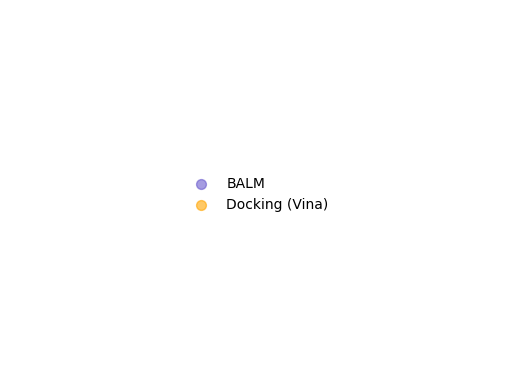

In [11]:
# Create and save the legend separately
legend_fig, legend_ax = plt.subplots()
legend_ax.axis('off')  # Hide axis
scatter1 = legend_ax.scatter([], [], color='#6A5ACD', alpha=0.6, s=50, label='BALM')
scatter2 = legend_ax.scatter([], [], color='orange', alpha=0.6, s=50, label='Docking (Vina)')
legend = legend_ax.legend(frameon=False, loc='center', ncol=1)
legend_path = os.path.join(output_folder, "legend.png")
legend_fig.savefig(legend_path, dpi=500, bbox_inches='tight')
print(f"Saved legend separately at {legend_path}")


In [19]:
import os
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error
import pandas as pd

# Load and prepare data
file_path = 'data/BALM+Dcoking_data.csv'
data = pd.read_csv(file_path)
data['rdock SCORE'] = data['rdock SCORE'] / 4.2
data['rdock SCORE.INTER'] = data['rdock SCORE.INTER'] / 4.2

# Apply pKd to ΔG conversion (assuming pkd_to_dg is defined)
data['label_dG'] = data.apply(lambda row: pkd_to_dg(row['Y'], 0.1)[0], axis=1)
data['prediction_dG'] = data.apply(lambda row: pkd_to_dg(row['prediction'], 0.1)[0], axis=1)

# Apply filtering conditions
target_counts_type = data['type'].value_counts()
targets_to_plot_type = target_counts_type[target_counts_type >= 10].index
filtered_data_type = data[(data['type'].isin(targets_to_plot_type)) & (data['type'] != 'other')]

# Remove rows with NaNs or infinite values in the raw columns
filtered_data_type = filtered_data_type.replace([np.inf, -np.inf], np.nan).dropna(
    subset=['label_dG', 'prediction_dG', 'rdock SCORE'])

# Disable LaTeX (since it requires external installation)
plt.rcParams['text.usetex'] = False

# Create output folder
output_folder = "plots/plots_BALM_rdock_SCORE"
os.makedirs(output_folder, exist_ok=True)

# Plot for each target type individually
font_size = 8  # Font size for compactness
font_color = 'grey'  # Grey color for all font in table
header_font_size = 8  # Smaller font size for headers to fit text fully
table_cell_pad = 0.15  # Reduced padding between cells for a more compact appearance

for target in filtered_data_type['type'].unique():
    target_data = filtered_data_type[filtered_data_type['type'] == target]
    target_data = target_data.dropna(subset=['label_dG'], how='any')

    # Create a new figure for each target
    fig, ax = plt.subplots(figsize=(8, 6))

    # Calculate metrics for BALM and Docking scores
    if len(target_data) > 1:
        pearson_corr_balm, _ = pearsonr(target_data['label_dG'], target_data['prediction_dG'])
        spearman_corr_balm, _ = spearmanr(target_data['label_dG'], target_data['prediction_dG'])
        kendall_corr_balm, _ = kendalltau(target_data['label_dG'], target_data['prediction_dG'])
        rmse_balm = mean_squared_error(target_data['label_dG'], target_data['prediction_dG'], squared=False)
        
        pearson_corr_docking, _ = pearsonr(target_data['label_dG'], target_data['rdock SCORE'])
        spearman_corr_docking, _ = spearmanr(target_data['label_dG'], target_data['rdock SCORE'])
        kendall_corr_docking, _ = kendalltau(target_data['label_dG'], target_data['rdock SCORE'])
        rmse_docking = mean_squared_error(target_data['label_dG'], target_data['rdock SCORE'], squared=False)

        # Data for the table with bold styling for the higher value in each row
        table_data = [
            ["Metric", "BALM", "Docking"],
            ["Pearson r", f"{pearson_corr_balm:.2f}", f"{pearson_corr_docking:.2f}"],
            ["Spearman ρ", f"{spearman_corr_balm:.2f}", f"{spearman_corr_docking:.2f}"],
            ["Kendall τ", f"{kendall_corr_balm:.2f}", f"{kendall_corr_docking:.2f}"],
            ["RMSE", f"{rmse_balm:.2f}", f"{rmse_docking:.2f}"]
        ]
    else:
        table_data = [["Metric", "BALM", "Docking"], ["Pearson r", "NA", "NA"], ["Spearman ρ", "NA", "NA"],
                      ["Kendall τ", "NA", "NA"], ["RMSE", "NA", "NA"]]

    # Plot data points
    ax.scatter(target_data['label_dG'], target_data['prediction_dG'], color='#6A5ACD', alpha=0.6, s=50, label='BALM')
    ax.scatter(target_data['label_dG'], target_data['rdock SCORE'], color='orange', alpha=0.6, s=50, label='Docking')

    # Identity line
    x = np.linspace(-18, -1, 100)
    ax.plot(x, x, color='#228B22', linestyle='-', linewidth=2, alpha=0.5)
    ax.fill_between(x, x - 1, x + 1, color='#228B22', alpha=0.2)
    ax.fill_between(x, x - 2, x + 2, color='#228B22', alpha=0.1)

    # Set limits, labels, and aspect ratio
    ax.set_xlim(-18, -1)
    ax.set_ylim(-18, -1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_ylabel(r'Predicted $\Delta G$ [kcal/mol]', fontsize=12)
    ax.set_xlabel(r'Experimental $\Delta G$ [kcal/mol]', fontsize=12)

    # Create the table with a solid line after the header row and an outer border
    table = ax.table(cellText=table_data, cellLoc='center', loc='lower right', bbox=[0.55, 0.02, 0.45, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(font_size)

    # Style table cells
    for (row, col), cell in table.get_celld().items():
        cell.set_text_props(color=font_color, ha='center')
        cell.PAD = table_cell_pad
        cell.set_linewidth(0)  # Remove all inner cell borders initially

        # Bold the header
        if row == 0:
            cell.set_text_props(fontweight='bold', fontsize=header_font_size)
        elif row > 0 and col > 0:
            try:
                # Check RMSE row to bold the lowest RMSE
                if row == 4:  # RMSE row
                    val_balm = float(table_data[row][1])
                    val_docking = float(table_data[row][2])
                    if (col == 1 and val_balm < val_docking) or (col == 2 and val_docking < val_balm):
                        cell.set_text_props(fontweight='bold')
                else:
                    # For other rows, bold the higher value
                    val_balm = float(table_data[row][1])
                    val_docking = float(table_data[row][2])
                    if (col == 1 and val_balm > val_docking) or (col == 2 and val_docking > val_balm):
                        cell.set_text_props(fontweight='bold')
            except ValueError:
                pass  # Ignore non-numeric values

    # Transform bounding box to axis coordinates
    bbox = table.get_window_extent(fig.canvas.get_renderer())
    inv = ax.transAxes.inverted()
    bbox = inv.transform(bbox)
    x0, y0 = bbox[0]
    x1, y1 = bbox[1]

    # Add rectangle around table using axis coordinates
    rect = Rectangle((x0 - 0.01, y0), x1 - x0, y1 - y0, linewidth=0.75, edgecolor='grey', facecolor='none', transform=ax.transAxes)
    ax.add_patch(rect)

    # Calculate the position for the dotted line
    line_y = y0 + (y1 - y0) * 0.8  # Adjust as necessary to place it just below the header row
    line = Line2D([x0 - 0.01, x1 - 0.01], [line_y, line_y], color='grey', linestyle='--', linewidth=0.75, transform=ax.transAxes)
    ax.add_line(line)

    # Save each plot individually without the legend
    fig_path = os.path.join(output_folder, f"{target}_plot.png")
    fig.savefig(fig_path, dpi=500, bbox_inches='tight')
    print(f"Saved plot for {target} at {fig_path}")

    # Close the figure to free up memory
    plt.close(fig)

# Create and save the legend separately
legend_fig, legend_ax = plt.subplots()
legend_ax.axis('off')  # Hide axis
scatter1 = legend_ax.scatter([], [], color='#6A5ACD', alpha=0.6, s=50, label='BALM')
scatter2 = legend_ax.scatter([], [], color='orange', alpha=0.6, s=50, label='Docking (rdock)')
legend = legend_ax.legend(frameon=False, loc='center', ncol=1)
legend_path = os.path.join(output_folder, "legend.png")
legend_fig.savefig(legend_path, dpi=500, bbox_inches='tight')
print(f"Saved legend separately at {legend_path}")

# Close the legend figure to free up memory
plt.close(legend_fig)


Saved plot for isomerase at plots/plots_BALM_rdock_SCORE/isomerase_plot.png
Saved plot for hydrolase at plots/plots_BALM_rdock_SCORE/hydrolase_plot.png
Saved plot for chaperone at plots/plots_BALM_rdock_SCORE/chaperone_plot.png
Saved plot for lyase at plots/plots_BALM_rdock_SCORE/lyase_plot.png
Saved plot for transcription at plots/plots_BALM_rdock_SCORE/transcription_plot.png
Saved plot for transport at plots/plots_BALM_rdock_SCORE/transport_plot.png
Saved plot for transferase at plots/plots_BALM_rdock_SCORE/transferase_plot.png
Saved plot for oxidoreductase at plots/plots_BALM_rdock_SCORE/oxidoreductase_plot.png
Saved plot for ligase at plots/plots_BALM_rdock_SCORE/ligase_plot.png
Saved plot for membrane at plots/plots_BALM_rdock_SCORE/membrane_plot.png
Saved plot for viral at plots/plots_BALM_rdock_SCORE/viral_plot.png
Saved plot for metal_containing at plots/plots_BALM_rdock_SCORE/metal_containing_plot.png
Saved legend separately at plots/plots_BALM_rdock_SCORE/legend.png


In [20]:
import os
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error
import pandas as pd

# Load and prepare data
file_path = 'data/BALM+Dcoking_data.csv'
data = pd.read_csv(file_path)
data['rdock SCORE'] = data['rdock SCORE'] / 4.2
data['rdock SCORE.INTER'] = data['rdock SCORE.INTER'] / 4.2

# Apply pKd to ΔG conversion (assuming pkd_to_dg is defined)
data['label_dG'] = data.apply(lambda row: pkd_to_dg(row['Y'], 0.1)[0], axis=1)
data['prediction_dG'] = data.apply(lambda row: pkd_to_dg(row['prediction'], 0.1)[0], axis=1)

# Apply filtering conditions
target_counts_type = data['type'].value_counts()
targets_to_plot_type = target_counts_type[target_counts_type >= 10].index
filtered_data_type = data[(data['type'].isin(targets_to_plot_type)) & (data['type'] != 'other')]

# Remove rows with NaNs or infinite values in the raw columns
filtered_data_type = filtered_data_type.replace([np.inf, -np.inf], np.nan).dropna(
    subset=['label_dG', 'prediction_dG', 'rdock SCORE.INTER'])

# Disable LaTeX (since it requires external installation)
plt.rcParams['text.usetex'] = False

# Create output folder
output_folder = "plots/plots_BALM_rdock_SCORE.Inter"
os.makedirs(output_folder, exist_ok=True)

# Plot for each target type individually
font_size = 8  # Font size for compactness
font_color = 'grey'  # Grey color for all font in table
header_font_size = 8  # Smaller font size for headers to fit text fully
table_cell_pad = 0.15  # Reduced padding between cells for a more compact appearance

for target in filtered_data_type['type'].unique():
    target_data = filtered_data_type[filtered_data_type['type'] == target]
    target_data = target_data.dropna(subset=['label_dG'], how='any')

    # Create a new figure for each target
    fig, ax = plt.subplots(figsize=(8, 6))

    # Calculate metrics for BALM and Docking scores
    if len(target_data) > 1:
        pearson_corr_balm, _ = pearsonr(target_data['label_dG'], target_data['prediction_dG'])
        spearman_corr_balm, _ = spearmanr(target_data['label_dG'], target_data['prediction_dG'])
        kendall_corr_balm, _ = kendalltau(target_data['label_dG'], target_data['prediction_dG'])
        rmse_balm = mean_squared_error(target_data['label_dG'], target_data['prediction_dG'], squared=False)
        
        pearson_corr_docking, _ = pearsonr(target_data['label_dG'], target_data['rdock SCORE.INTER'])
        spearman_corr_docking, _ = spearmanr(target_data['label_dG'], target_data['rdock SCORE.INTER'])
        kendall_corr_docking, _ = kendalltau(target_data['label_dG'], target_data['rdock SCORE.INTER'])
        rmse_docking = mean_squared_error(target_data['label_dG'], target_data['rdock SCORE.INTER'], squared=False)

        # Data for the table with bold styling for the higher value in each row
        table_data = [
            ["Metric", "BALM", "Docking"],
            ["Pearson r", f"{pearson_corr_balm:.2f}", f"{pearson_corr_docking:.2f}"],
            ["Spearman ρ", f"{spearman_corr_balm:.2f}", f"{spearman_corr_docking:.2f}"],
            ["Kendall τ", f"{kendall_corr_balm:.2f}", f"{kendall_corr_docking:.2f}"],
            ["RMSE", f"{rmse_balm:.2f}", f"{rmse_docking:.2f}"]
        ]
    else:
        table_data = [["Metric", "BALM", "Docking"], ["Pearson r", "NA", "NA"], ["Spearman ρ", "NA", "NA"],
                      ["Kendall τ", "NA", "NA"], ["RMSE", "NA", "NA"]]

    # Plot data points
    ax.scatter(target_data['label_dG'], target_data['prediction_dG'], color='#6A5ACD', alpha=0.6, s=50, label='BALM')
    ax.scatter(target_data['label_dG'], target_data['rdock SCORE.INTER'], color='orange', alpha=0.6, s=50, label='Docking')

    # Identity line
    x = np.linspace(-18, -1, 100)
    ax.plot(x, x, color='#228B22', linestyle='-', linewidth=2, alpha=0.5)
    ax.fill_between(x, x - 1, x + 1, color='#228B22', alpha=0.2)
    ax.fill_between(x, x - 2, x + 2, color='#228B22', alpha=0.1)

    # Set limits, labels, and aspect ratio
    ax.set_xlim(-18, -1)
    ax.set_ylim(-18, -1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_ylabel(r'Predicted $\Delta G$ [kcal/mol]', fontsize=12)
    ax.set_xlabel(r'Experimental $\Delta G$ [kcal/mol]', fontsize=12)

    # Create the table with a solid line after the header row and an outer border
    table = ax.table(cellText=table_data, cellLoc='center', loc='lower right', bbox=[0.55, 0.02, 0.45, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(font_size)

    # Style table cells
    for (row, col), cell in table.get_celld().items():
        cell.set_text_props(color=font_color, ha='center')
        cell.PAD = table_cell_pad
        cell.set_linewidth(0)  # Remove all inner cell borders initially

        # Bold the header
        if row == 0:
            cell.set_text_props(fontweight='bold', fontsize=header_font_size)
        elif row > 0 and col > 0:
            try:
                # Check RMSE row to bold the lowest RMSE
                if row == 4:  # RMSE row
                    val_balm = float(table_data[row][1])
                    val_docking = float(table_data[row][2])
                    if (col == 1 and val_balm < val_docking) or (col == 2 and val_docking < val_balm):
                        cell.set_text_props(fontweight='bold')
                else:
                    # For other rows, bold the higher value
                    val_balm = float(table_data[row][1])
                    val_docking = float(table_data[row][2])
                    if (col == 1 and val_balm > val_docking) or (col == 2 and val_docking > val_balm):
                        cell.set_text_props(fontweight='bold')
            except ValueError:
                pass  # Ignore non-numeric values

    # Transform bounding box to axis coordinates
    bbox = table.get_window_extent(fig.canvas.get_renderer())
    inv = ax.transAxes.inverted()
    bbox = inv.transform(bbox)
    x0, y0 = bbox[0]
    x1, y1 = bbox[1]

    # Add rectangle around table using axis coordinates
    rect = Rectangle((x0 - 0.01, y0), x1 - x0, y1 - y0, linewidth=0.75, edgecolor='grey', facecolor='none', transform=ax.transAxes)
    ax.add_patch(rect)

    # Calculate the position for the dotted line
    line_y = y0 + (y1 - y0) * 0.8  # Adjust as necessary to place it just below the header row
    line = Line2D([x0 - 0.01, x1 - 0.01], [line_y, line_y], color='grey', linestyle='--', linewidth=0.75, transform=ax.transAxes)
    ax.add_line(line)

    # Save each plot individually without the legend
    fig_path = os.path.join(output_folder, f"{target}_plot.png")
    fig.savefig(fig_path, dpi=500, bbox_inches='tight')
    print(f"Saved plot for {target} at {fig_path}")

    # Close the figure to free up memory
    plt.close(fig)

# Create and save the legend separately
legend_fig, legend_ax = plt.subplots()
legend_ax.axis('off')  # Hide axis
scatter1 = legend_ax.scatter([], [], color='#6A5ACD', alpha=0.6, s=50, label='BALM')
scatter2 = legend_ax.scatter([], [], color='orange', alpha=0.6, s=50, label='Docking (rdock)')
legend = legend_ax.legend(frameon=False, loc='center', ncol=1)
legend_path = os.path.join(output_folder, "legend.png")
legend_fig.savefig(legend_path, dpi=500, bbox_inches='tight')
print(f"Saved legend separately at {legend_path}")

# Close the legend figure to free up memory
plt.close(legend_fig)


Saved plot for isomerase at plots/plots_BALM_rdock_SCORE.Inter/isomerase_plot.png
Saved plot for hydrolase at plots/plots_BALM_rdock_SCORE.Inter/hydrolase_plot.png
Saved plot for chaperone at plots/plots_BALM_rdock_SCORE.Inter/chaperone_plot.png
Saved plot for lyase at plots/plots_BALM_rdock_SCORE.Inter/lyase_plot.png
Saved plot for transcription at plots/plots_BALM_rdock_SCORE.Inter/transcription_plot.png
Saved plot for transport at plots/plots_BALM_rdock_SCORE.Inter/transport_plot.png
Saved plot for transferase at plots/plots_BALM_rdock_SCORE.Inter/transferase_plot.png
Saved plot for oxidoreductase at plots/plots_BALM_rdock_SCORE.Inter/oxidoreductase_plot.png
Saved plot for ligase at plots/plots_BALM_rdock_SCORE.Inter/ligase_plot.png
Saved plot for membrane at plots/plots_BALM_rdock_SCORE.Inter/membrane_plot.png
Saved plot for viral at plots/plots_BALM_rdock_SCORE.Inter/viral_plot.png
Saved plot for metal_containing at plots/plots_BALM_rdock_SCORE.Inter/metal_containing_plot.png
Save